
*   **Group Member:** Seyit Semih Yiğitarslan (Group 08)
*   **METU Student Number:** 2655074
*   ssyigitarslan@gmail.com & e265507@metu.edu.tr
METU CENG796
# Paper Title: END-TO-END DEEP STRUCTURE GENERATIVE MODELFOR PROTEIN DESIGN
*   **Paper Link:** https://www.biorxiv.org/content/10.1101/2022.07.09.499440v1.full.pdf
*   **Paper Authors:** Boqiao Lai, Jinbo Xu∗, and Matt McPartlon




**INTRODUCTION**

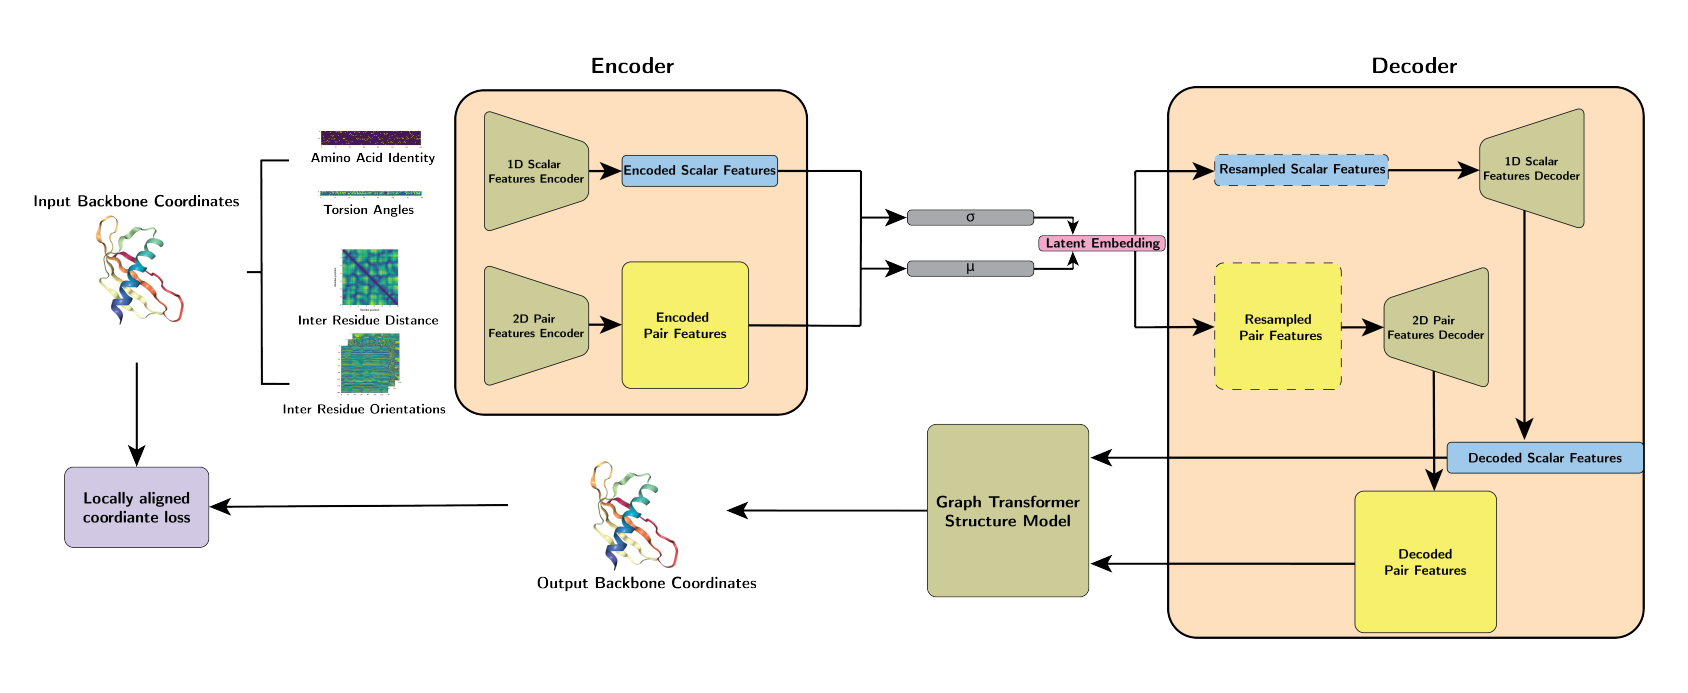


Model Overview

In this project, the aim is to predict new 3D protein models using the data set obtained from the CATH4.2 protein bank within the scope of the CENG796 course, using the VAE (Variational Autoencoder) approach.

The main.ipynb file explains how to download the data set, how the generative model approach works, and the challenges encountered in the project. However, due to an issue in running the model, no progress could be made beyond a certain point.

Prediction of protein structure and function at the amino acid level is important, and this project aims to develop protein design and variant prediction using VAE approaches

Proteins are essential for life, and accurate computational methods are needed to predict their structures and understand variations at the amino acid level

Feature Extraction: The model separates protein structures into matched (inter-residue distance and orientation) and scalar (torsion angles and amino acid sequence) features.

Encoding of Features: The model encodes matched and scalar features separately into a latent space.

Sampling and Decoding: After the latent representation is sampled and decoded by matched and scalar feature decoders, it is fed into a graph transformer-based structure module.

Local Alignment Loss Calculation: A local alignment loss is calculated between the reconstructed coordinates and the local input structure.

Configuration of Protein Structures and Torsion Angles: The model can consistently generate high-quality structure coordinates for target proteins.

In the mathematical representation of this process, the model creates representations of scalar and paired features and applies various masks. Additionally, the VAE framework is implemented as a decoder architecture within this model.

Key points:

A Variational Autoencoder (VAE), Transformer, Autoregressive Models are used in this study.

The model learns and reconstructs the 3D structures of proteins.

A series of mathematical operations and formulas are used in the model for feature extraction, encoding, reconstruction, and calculation of alignment loss.

The model creates a folding space containing useful information using the latent representation of input proteins.

The results demonstrate that the 3D structures of proteins and high-quality structure coordinates for target proteins can be successfully generated.

In [1]:
# END-TO-END DEEP STRUCTURE GENERATIVE MODELFOR PROTEIN DESIGN

**Connection Google Drive**

In [2]:
# Located the main file
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/CENG796

/content/drive/MyDrive/CENG796


# Import necessary libraries, and files

In [4]:
# Download biopython
!pip install biopython
!pip install py3Dmol

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from functions_of_projects import *
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from Bio.PDB import PDBParser, Superimposer
import json
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

# model
from vae_sample import VAE
from vae_transformer import VAETransformer
from autoregressive_model import AutoregressiveModel
from vae_v1 import VAE_v1
from vae_transformer_v1 import VAETransformer_v1

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.pyplot as plt

import py3Dmol
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**HyperParameters**


```
input_dim 
hidden_dim 
kernel_size
dilation_rate
batch_size_auto # for autoregressive model
bathc_size      # for VAE, and VAE Transform
input_size
latent_size
num_heads
num_layers
learning_rate
```





**Dataset**

Download the CATH4.2 dataset from the desired website.

Dataset from [Generative Models Paper](https://www.mit.edu/~vgarg/GenerativeModelsForProteinDesign.pdf)      

> [Github Link](https://github.com/jingraham/neurips19-graph-protein-design)

> [Dataset Link](http://people.csail.mit.edu/ingraham/graph-protein-design/data/)





In [6]:
# Use this code to download dataset, and use local machine (linux) Thanks to this, dirs cut with 2 times, and data folder saved on the desired path
#open to download dataset
"""
!wget -r -np -nH --cut-dirs=2 --reject "index.html*" http://people.csail.mit.edu/ingraham/graph-protein-design/data/"""


'\n!wget -r -np -nH --cut-dirs=2 --reject "index.html*" http://people.csail.mit.edu/ingraham/graph-protein-design/data/'

Desired dataset path

In [7]:
# project path
%cd /content/drive/MyDrive/CENG796
dataset_path = "data/"

/content/drive/MyDrive/CENG796



The aim was to visualize the 3D protein models from chain_set.jsonl (based on the sequence and coord connections). The visualization of the protein model in 3D was intended for the protein modeling approach shown in Figure 2a.

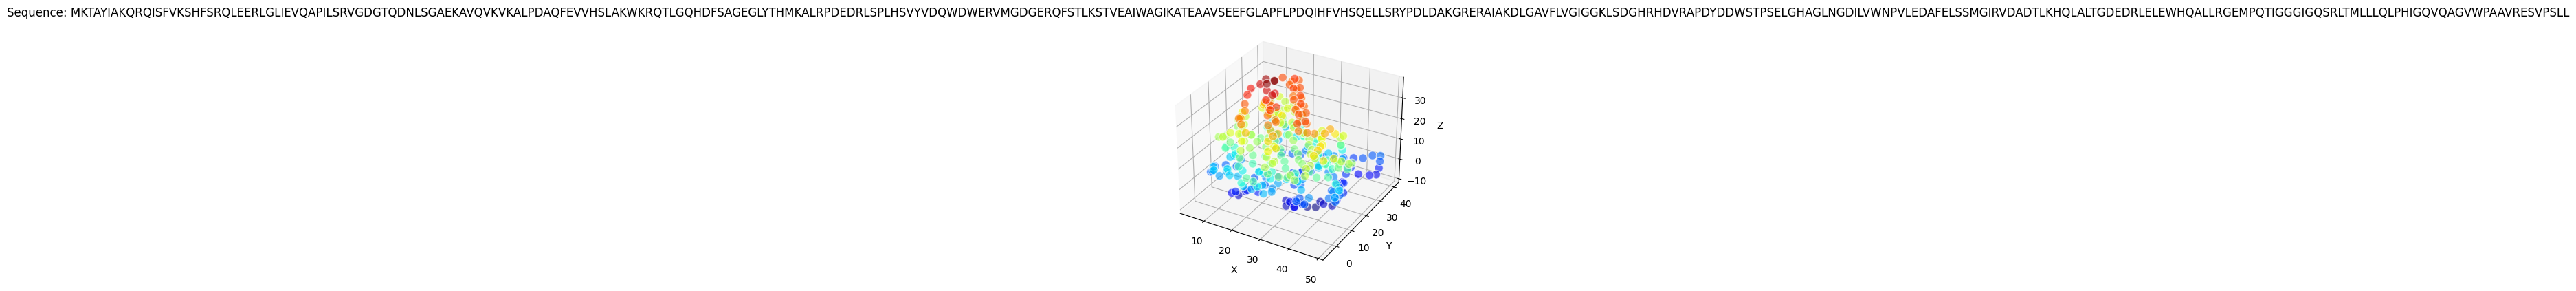

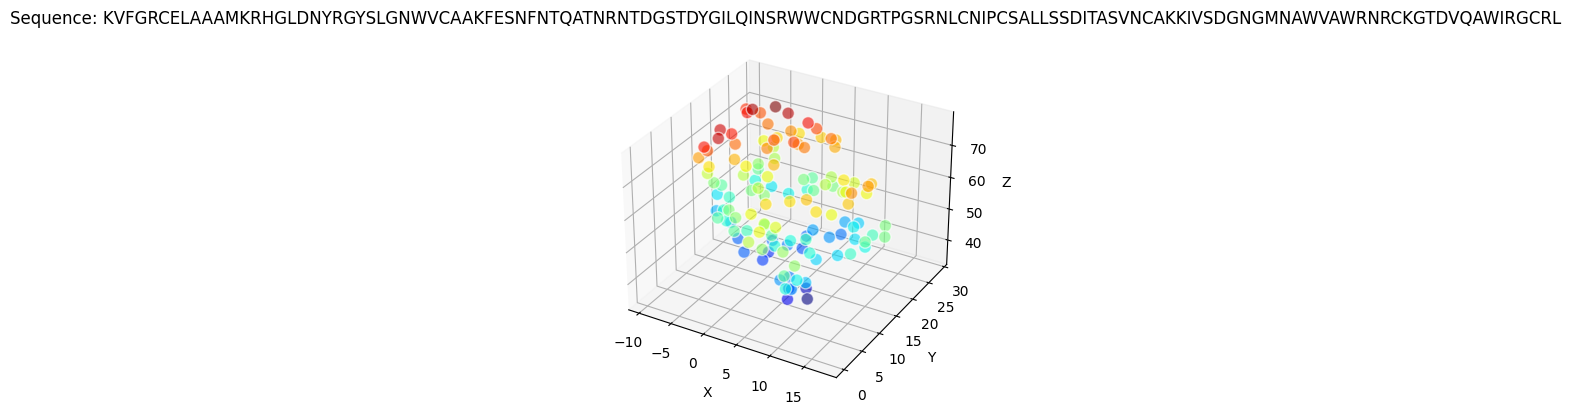

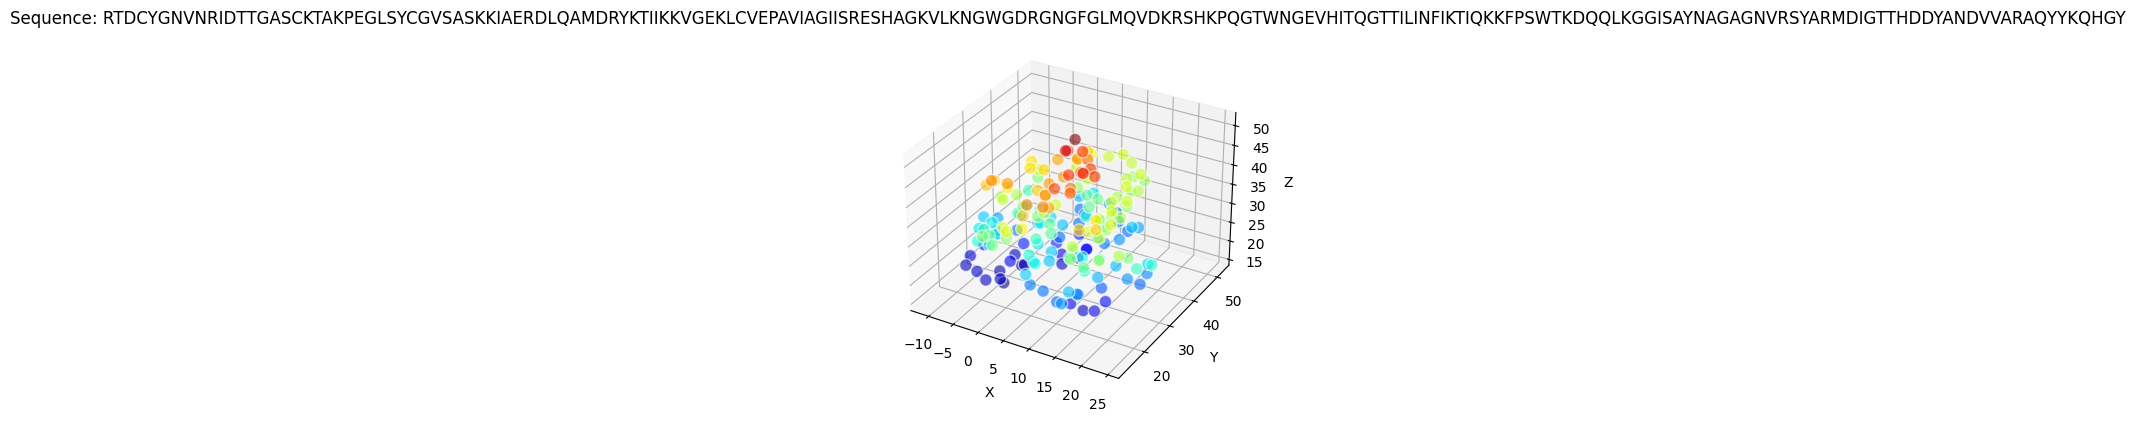

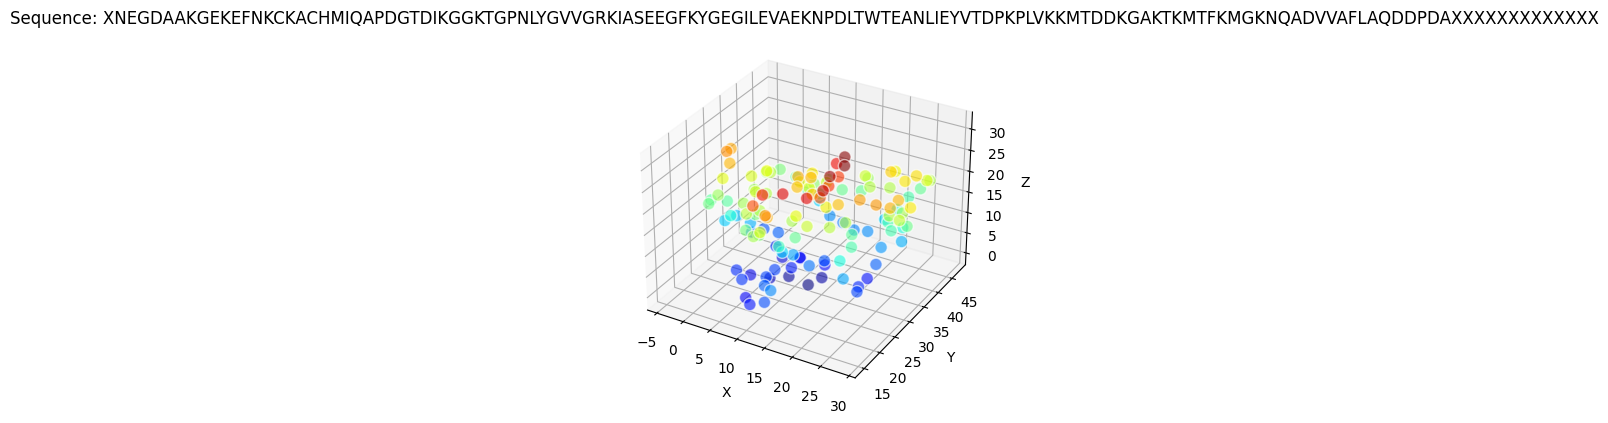

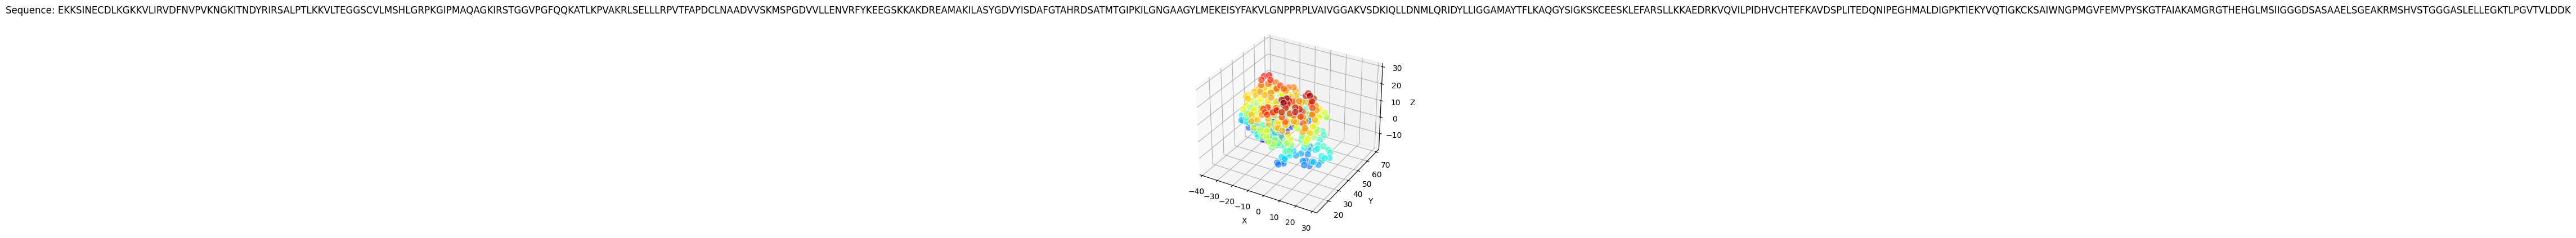

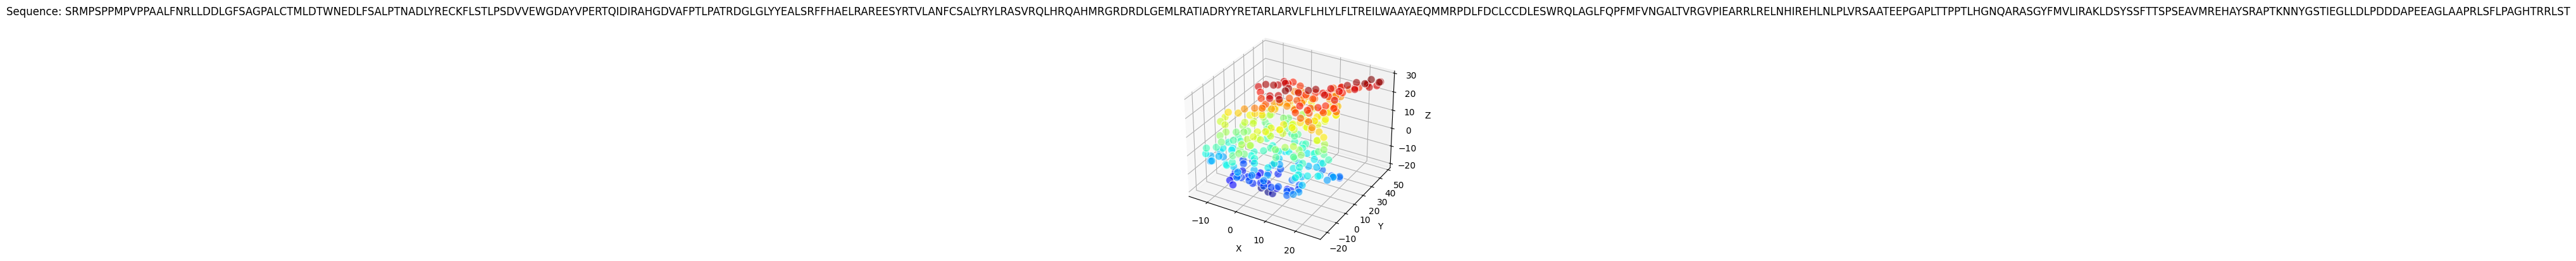

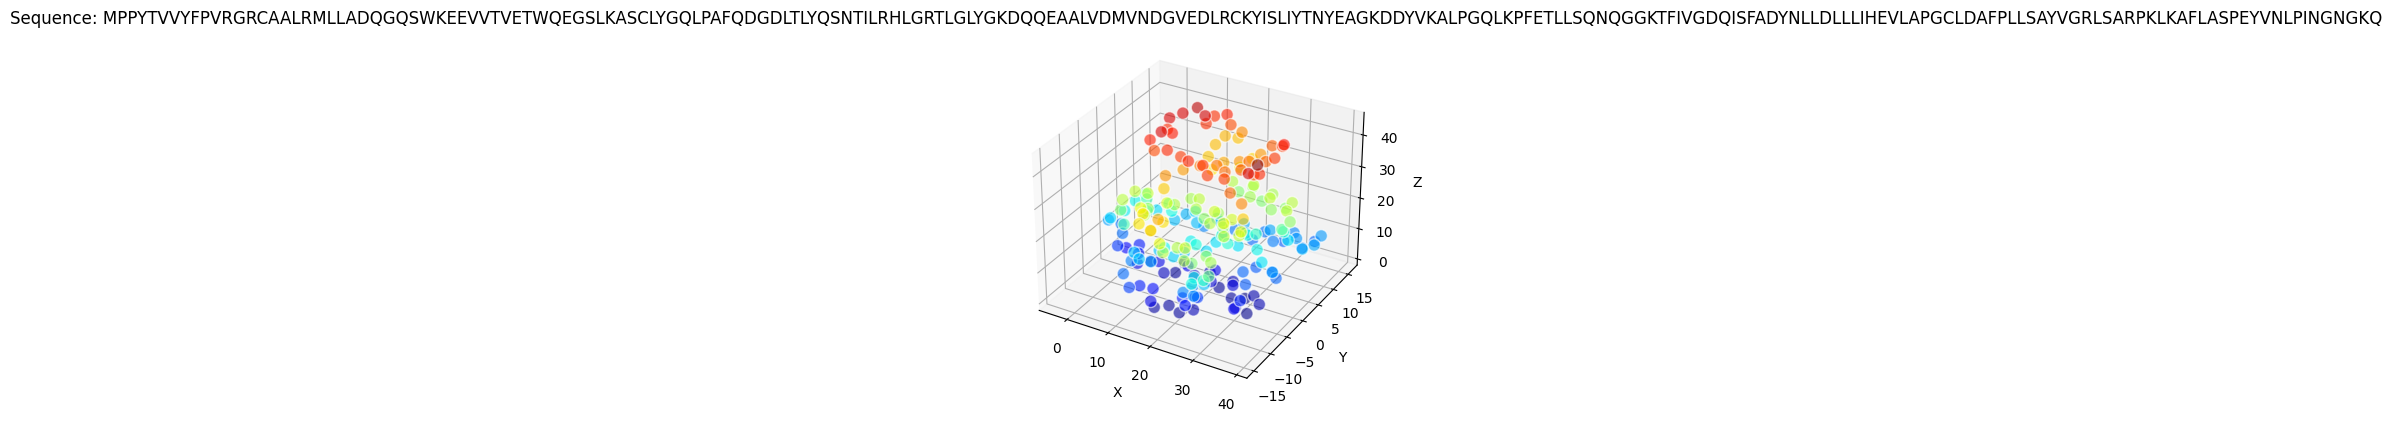

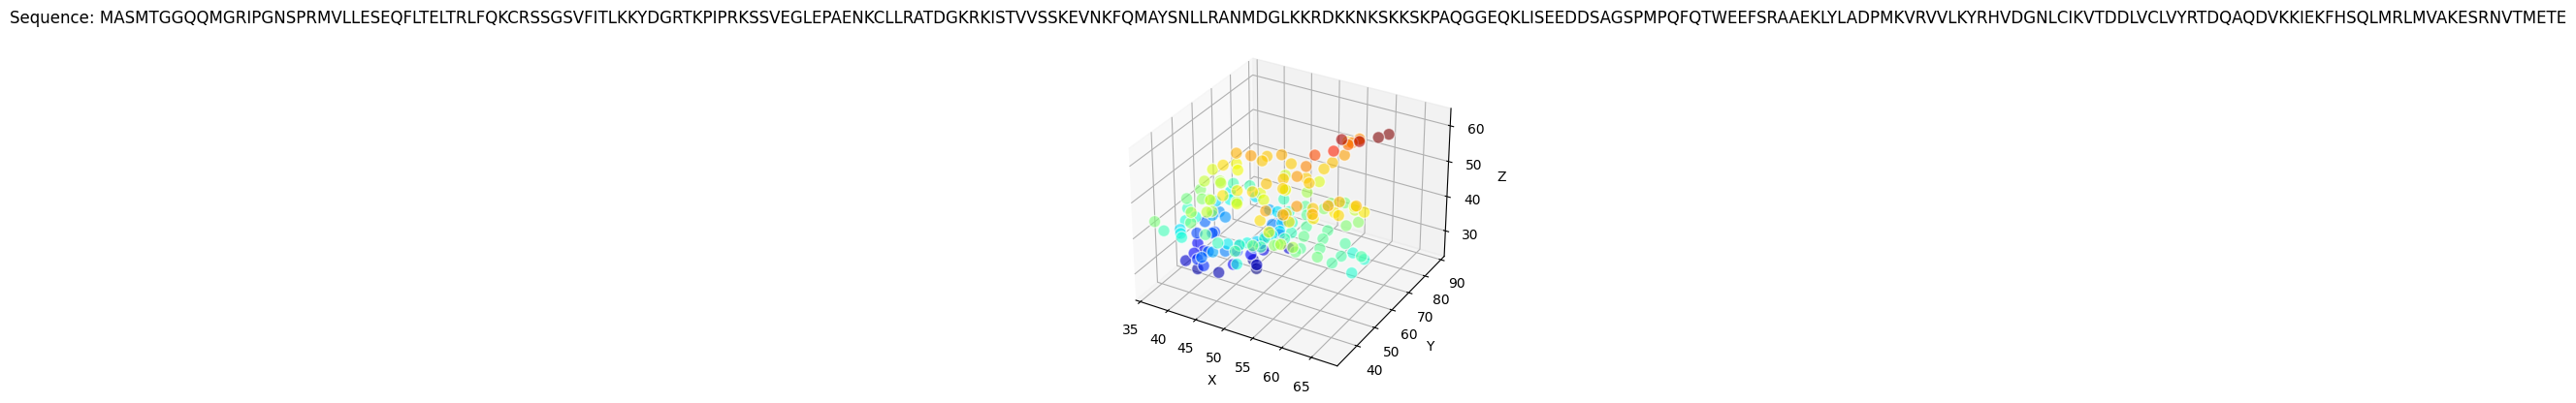

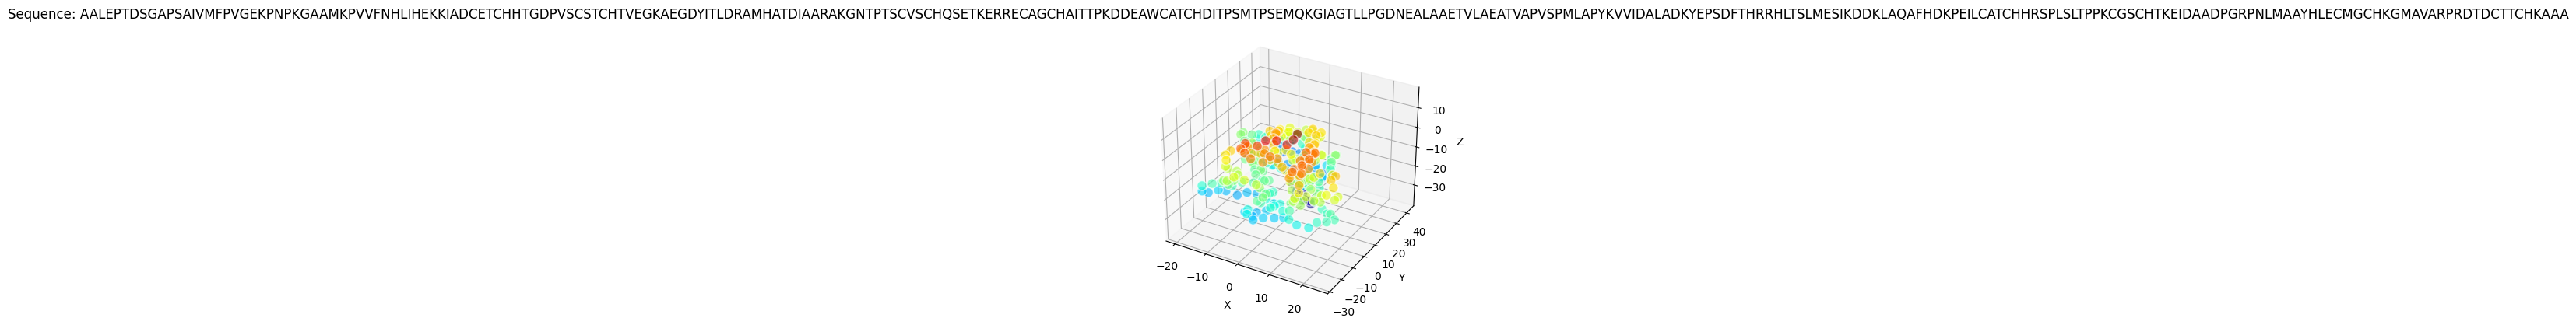

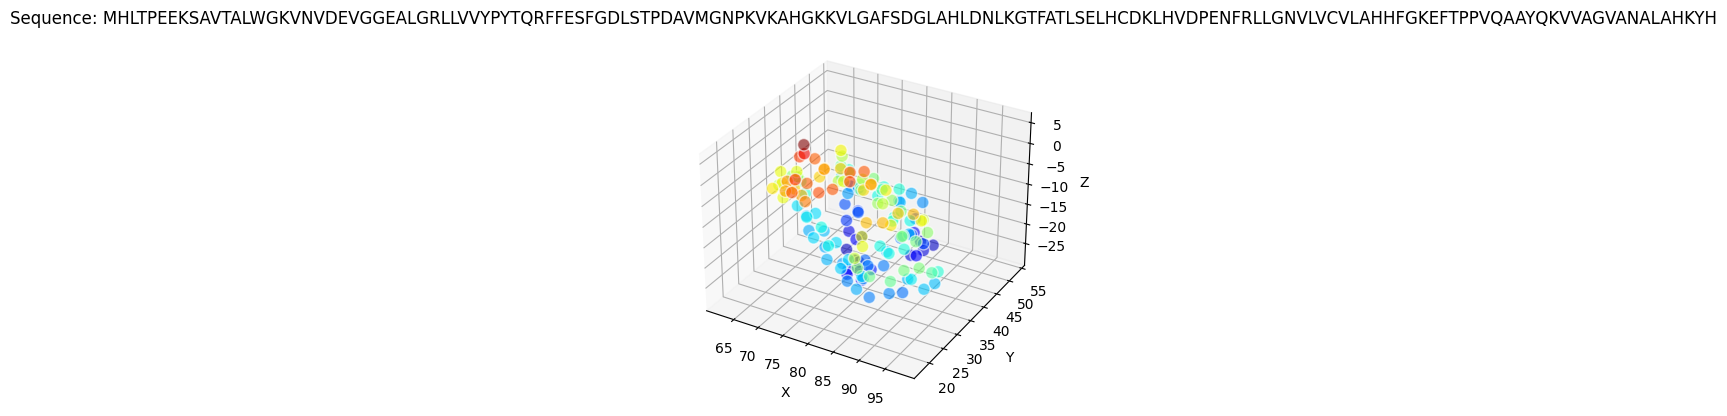

<ipython-input-8-01fb9e15e5f7>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coordinate_data = np.array(coordinate_data)


In [8]:
# Open JSON Lines file and load its content
with open('data/cath/chain_set.jsonl', 'r') as f:
    lines = f.readlines()

# To store sequence and coordinates data
sequence_data = []
coordinate_data = []

# For each chain, create a 3D image 
# Render figures for the first 10, just store the rest as arrays
for idx, line in enumerate(lines):
    chain_data = json.loads(line)  # Parse JSON line into python object
    seq = chain_data['seq']  # Extract sequence data
    coordinates = chain_data['coords']['N']  # Extract coordinates data
    coordinates = np.array(coordinates)  # Convert list of coordinates to numpy array

    # Store sequence and coordinates data
    sequence_data.append(seq)
    coordinate_data.append(coordinates)

    # Plot the first 10 chains
    if idx < 10:
        # Create a 3D figure
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')  # Set 3D projection
        # Scatter plot with color map based on Z-axis values, semi-transparent points with white edges
        ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c=coordinates[:, 2], cmap='jet', alpha=0.6, edgecolors='w', s=80)
        ax.set_xlabel('X')  # Label X-axis
        ax.set_ylabel('Y')  # Label Y-axis
        ax.set_zlabel('Z')  # Label Z-axis
        plt.title(f"Sequence: {seq}")  # Add a title showing sequence data
        plt.show()  # Display the plot

# Convert all sequence and coordinates data to numpy arrays for further processing
sequence_data = np.array(sequence_data)       
coordinate_data = np.array(coordinate_data)



**sequence array**



# Analyze first 5 data

In [9]:
file_path_jsonl = "/content/drive/MyDrive/CENG796/data/cath/chain_set.jsonl"
jsonl_file_path = "/content/drive/MyDrive/CENG796/data/cath/chain_set.jsonl"

# Read example JSON file
json_file_path = '/content/drive/MyDrive/CENG796/data/cath/chain_set_splits.json'
json_data = read_json_file(json_file_path)

# Read example JSONL file
jsonl_data = read_jsonl_file(jsonl_file_path)

# Analyze the first 5 JSON data
analyze_json_data(json_data, 5)

# Analyze the first 5 JSONL data
analyze_jsonl_data(jsonl_data, 5)


JSON Data 1: Name: {'test': ['3fkf.A', '2d9e.A', '2lkl.A', '1ud9.A', '2rem.B', '2d8d.B', '1kll.A', '1ifw.A', '1buq.A', '1lu4.A', '4dw0.A', '1d1r.A', '1nnv.A', '2caz.C', '3zf8.A', '3d4e.A', '2lp7.A', '2myg.A', '1m2a.A', '3ga2.A', '3c7m.A', '2pb9.A', '3drn.B', '3iu5.A', '1of5.A', '2h8l.A', '1d2i.A', '3gm5.A', '2dlx.A', '3g16.A', '3g8z.A', '1fxk.B', '1fxk.C', '2pqg.B', '5evh.A', '2gta.A', '3lyg.A', '1z52.A', '2ehz.A', '4ccv.A', '3d1b.B', '1qw2.A', '1ge8.A', '2k3d.A', '1waz.A', '4fyb.A', '4hpq.B', '2zdi.C', '3gzb.A', '1ynj.K', '4h61.A', '1nio.A', '1l3a.A', '1gh2.A', '4m6r.A', '4z04.A', '2gts.A', '4jrr.B', '1xvw.A', '1aal.B', '2hii.A', '4pif.A', '4iqj.M', '3h5k.A', '1dm0.L', '4kl0.A', '2gia.B', '2krt.A', '2lcj.A', '1lp8.A', '1sb7.A', '4mix.A', '2m72.A', '1iur.A', '1f9x.A', '1f9z.A', '4pav.A', '1rl0.A', '3ira.A', '2lus.A', '3fkm.X', '2i82.A', '3e5d.A', '2ahy.A', '3emx.A', '3ct8.A', '2w35.A', '3lwa.A', '3kp9.A', '5c8g.B', '3ed3.A', '3mqm.A', '3gha.A', '1x4t.A', '1wpi.A', '4cw9.B', '3fn5.B', '

In [10]:
jsonl_data[0].keys()

dict_keys(['seq', 'coords', 'num_chains', 'name', 'CATH'])


# Detailed Analysis of Protein Sequence Datasetdataset

in .json file we have, train, test, and validation indexes.
in .json file we have original datas.

In [11]:
len(json_data[0].keys())
print(json_data[0].keys())
print("length of test is: " + str(len(json_data[0]["test"])))
print("length of cath_nodes is: " + str(len(json_data[0]["cath_nodes"])))
print("length of train is: " + str(len(json_data[0]["train"])))
print("length of validation is: " + str(len(json_data[0]["validation"])))
print(json_data[0]["train"])

dict_keys(['test', 'cath_nodes', 'train', 'validation'])
length of test is: 1120
length of cath_nodes is: 21573
length of train is: 18024
length of validation is: 608
['2fyz.A', '4nav.A', '3kbr.A', '4uhc.A', '3k4u.A', '2yrr.A', '3m2p.A', '1uyp.A', '3bje.A', '1rj8.A', '3lp5.A', '1z3x.A', '2ozz.A', '3r0a.A', '3pnr.A', '3u3z.A', '3pnr.B', '2ovr.B', '4hw0.A', '1hnn.A', '1qdp.A', '3vpr.A', '1pdo.A', '1nlf.A', '3nwo.A', '3ii7.A', '4dcz.A', '3lr5.A', '3bzb.A', '3eef.A', '1pq4.A', '3jvd.A', '1a7v.A', '3dh1.B', '1st0.A', '4mn5.A', '4hty.A', '3bww.A', '4r5z.A', '4i0w.A', '2l3n.A', '4g43.A', '1jji.A', '5evi.C', '2gqt.A', '2ozb.E', '1w5s.A', '4kb2.A', '2bko.A', '4mt0.A', '2o6l.A', '3vpz.A', '2hrz.A', '2rek.A', '3dcx.A', '2wno.A', '4ngd.A', '3gfz.B', '1zt4.C', '1m5w.A', '1wza.A', '5f67.B', '3t7a.A', '2i0r.A', '1q74.B', '1q02.A', '1z0j.B', '2pqq.A', '1tk1.A', '3r4r.A', '1s6l.A', '1gyx.A', '4yvo.A', '1yd7.A', '2o9x.A', '3gre.A', '2fm7.A', '1vcv.A', '2f3x.A', '1x57.A', '3og4.B', '1eok.A', '3gl9.A', '2

**Objects of jsonl file**



In [12]:
jsonl_data[0].keys()

dict_keys(['seq', 'coords', 'num_chains', 'name', 'CATH'])

**Objects of json file**



In [13]:
json_data[0].keys()

dict_keys(['test', 'cath_nodes', 'train', 'validation'])

**Atom names of Coords**

In [14]:
jsonl_data[0]["coords"].keys()

dict_keys(['N', 'CA', 'C', 'O'])

**Analyse length of desired objects**

In [15]:
ij = 0
length_sequence = []
length_coords_N = []
length_coords_CA = []
length_coords_C = []
length_coords_O = []
length_name = []
length_CATH = []
while ij < len(jsonl_data):
  length_sequence.append(len(jsonl_data[ij]["seq"]))
  length_coords_N.append(len(jsonl_data[ij]["coords"]["N"]))
  length_coords_CA.append(len(jsonl_data[ij]["coords"]["CA"]))
  length_coords_C.append(len(jsonl_data[ij]["coords"]["C"]))
  length_coords_O.append(len(jsonl_data[ij]["coords"]["O"]))
  length_name.append(len(jsonl_data[ij]["name"]))
  length_CATH.append(len(jsonl_data[ij]["CATH"]))
  ij = ij + 1

**Analyse length, and dimension of the dataset to reduct or add new values**

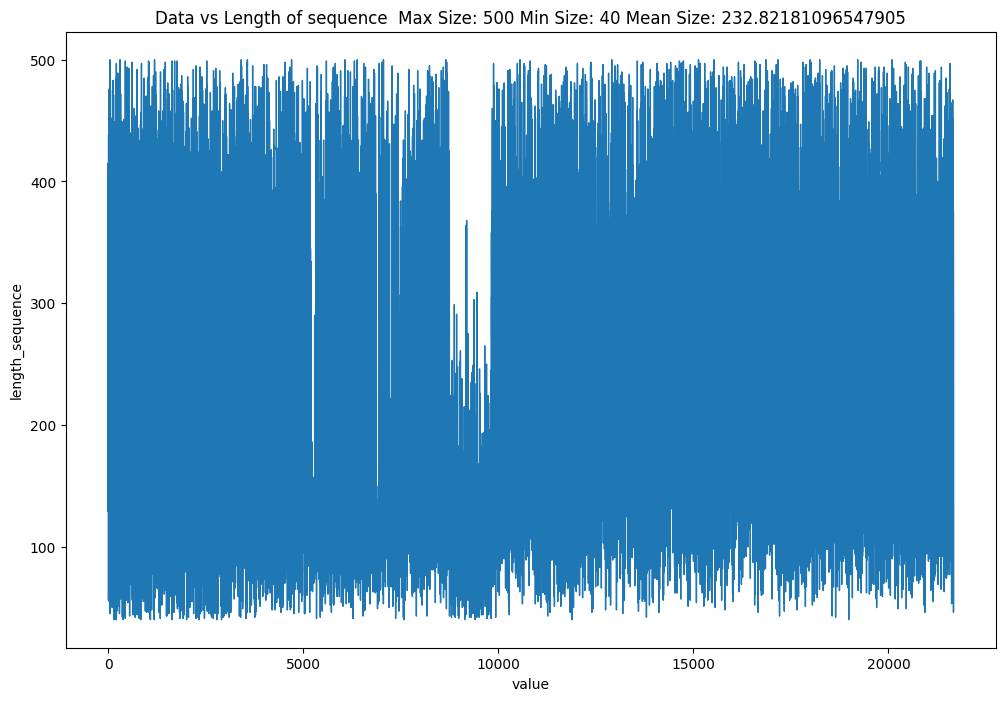

<Figure size 640x480 with 0 Axes>

In [16]:
from functions_of_projects import *
plot_data_x(len(length_sequence), length_sequence, "sequence")



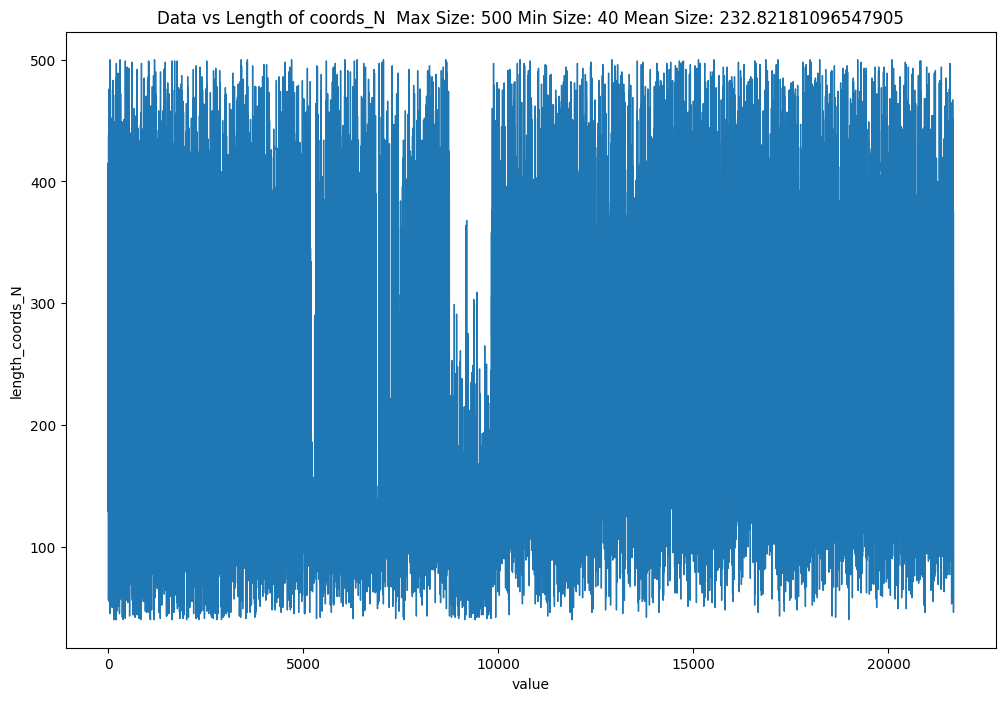

<Figure size 640x480 with 0 Axes>

In [17]:
plot_data_x(len(length_coords_N), length_coords_N, "coords_N")


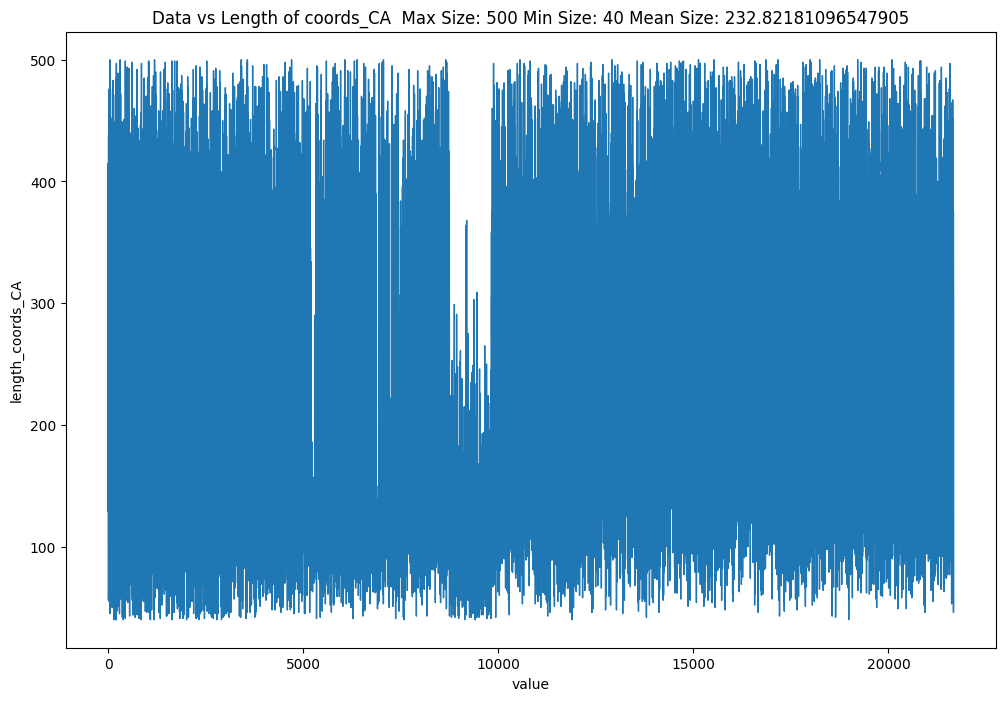

<Figure size 640x480 with 0 Axes>

In [18]:
plot_data_x(len(length_coords_CA), length_coords_CA, "coords_CA")


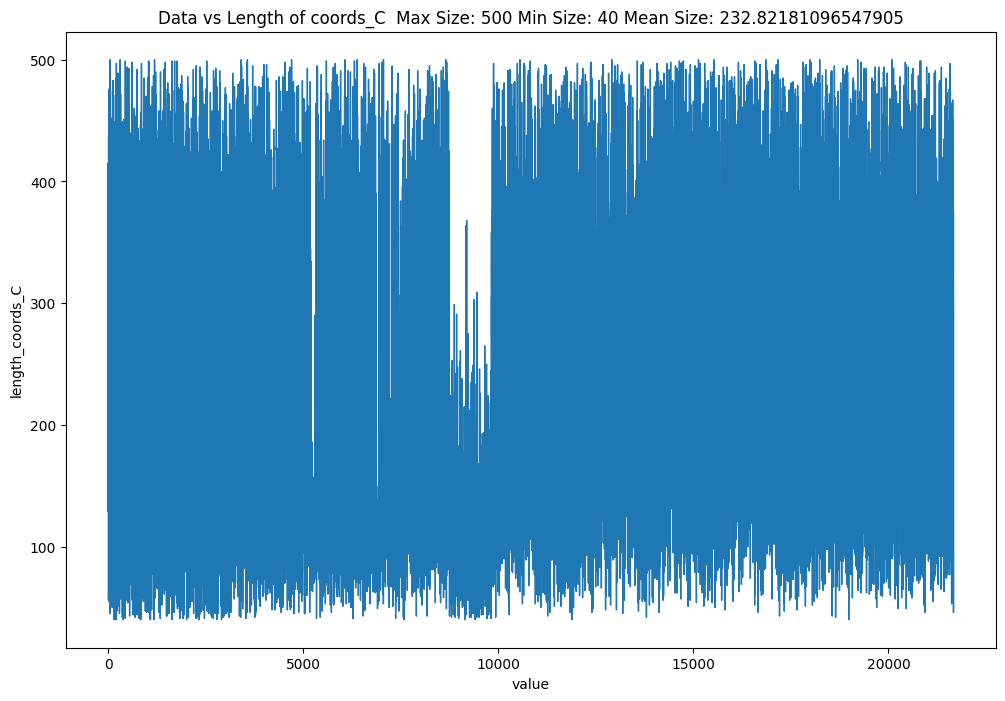

<Figure size 640x480 with 0 Axes>

In [19]:
plot_data_x(len(length_coords_C), length_coords_C, "coords_C")


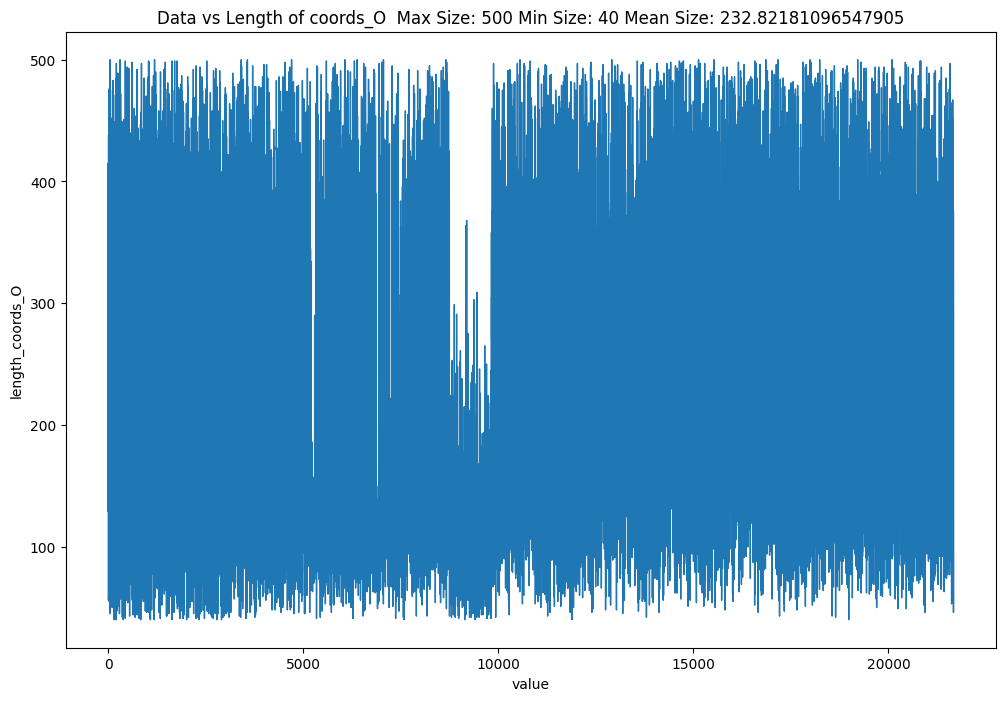

<Figure size 640x480 with 0 Axes>

In [20]:
plot_data_x(len(length_coords_O), length_coords_O, "coords_O")


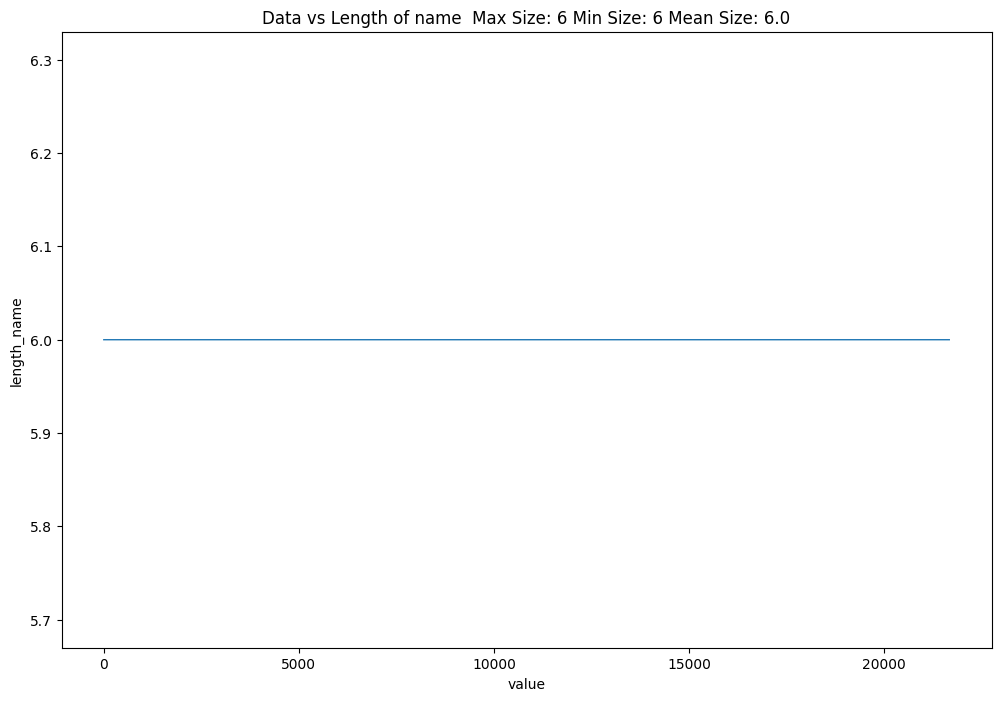

<Figure size 640x480 with 0 Axes>

In [21]:
plot_data_x(len(length_name), length_name, "name")



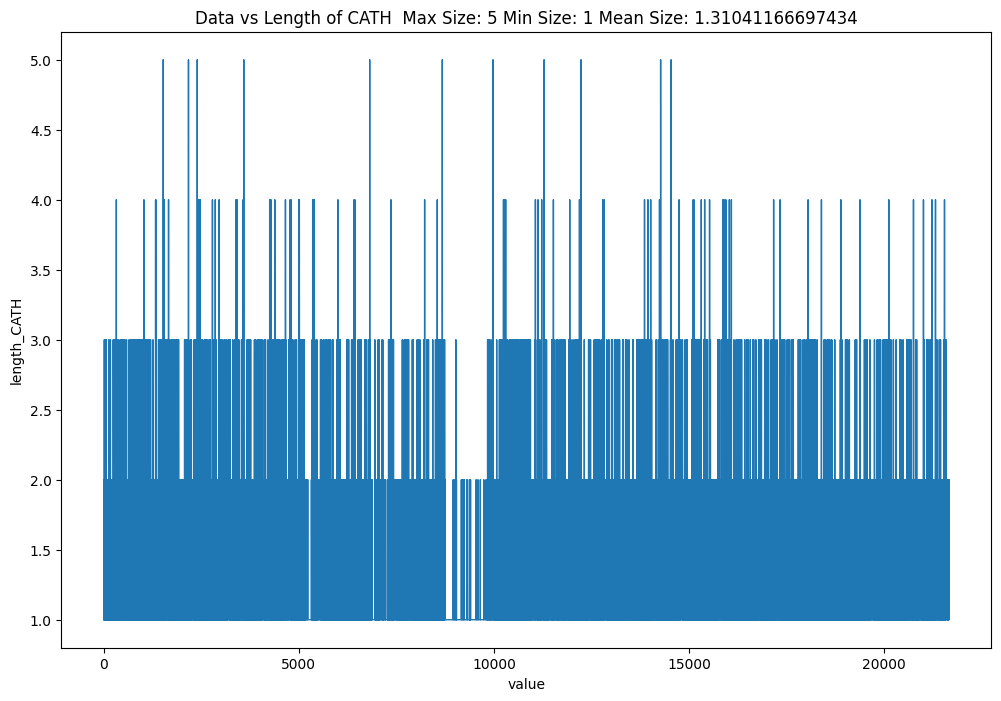

<Figure size 640x480 with 0 Axes>

In [22]:
plot_data_x(len(length_CATH), length_CATH, "CATH")


**Reduct the dataset**

In [23]:
ij = 0
reduct_sequence = []
reduct_coords_N = []
reduct_coords_CA = []
reduct_coords_C = []
reduct_coords_O = []
reduct_name = []
reduct_CATH = []
while ij < len(jsonl_data):
  reduct_sequence.append(jsonl_data[ij]["seq"][0: normalize_data_len_10_50(jsonl_data[ij]["seq"])])
  reduct_coords_N.append(jsonl_data[ij]["coords"]["N"][0: normalize_data_len_10_50(jsonl_data[ij]["coords"]["N"])])
  reduct_coords_CA.append(jsonl_data[ij]["coords"]["CA"][0: normalize_data_len_10_50(jsonl_data[ij]["coords"]["CA"])])
  reduct_coords_C.append(jsonl_data[ij]["coords"]["C"][0: normalize_data_len_10_50(jsonl_data[ij]["coords"]["C"])])
  reduct_coords_O.append(jsonl_data[ij]["coords"]["O"][0: normalize_data_len_10_50(jsonl_data[ij]["coords"]["O"])])
  reduct_name.append(jsonl_data[ij]["name"])
  reduct_CATH.append(jsonl_data[ij]["CATH"])
  ij = ij + 1

In [24]:
analyze_objects = ["reduct_sequence","reduct_coords_N","reduct_coords_CA","reduct_coords_C","reduct_coords_O","reduct_name","reduct_CATH"]

In [25]:
reduct_array = np.array([reduct_sequence, reduct_coords_N, reduct_coords_CA, reduct_coords_C, reduct_coords_O, reduct_name, reduct_CATH])

<ipython-input-25-e5d8e5c5bce0>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  reduct_array = np.array([reduct_sequence, reduct_coords_N, reduct_coords_CA, reduct_coords_C, reduct_coords_O, reduct_name, reduct_CATH])


#*Plot the reduct dataset*

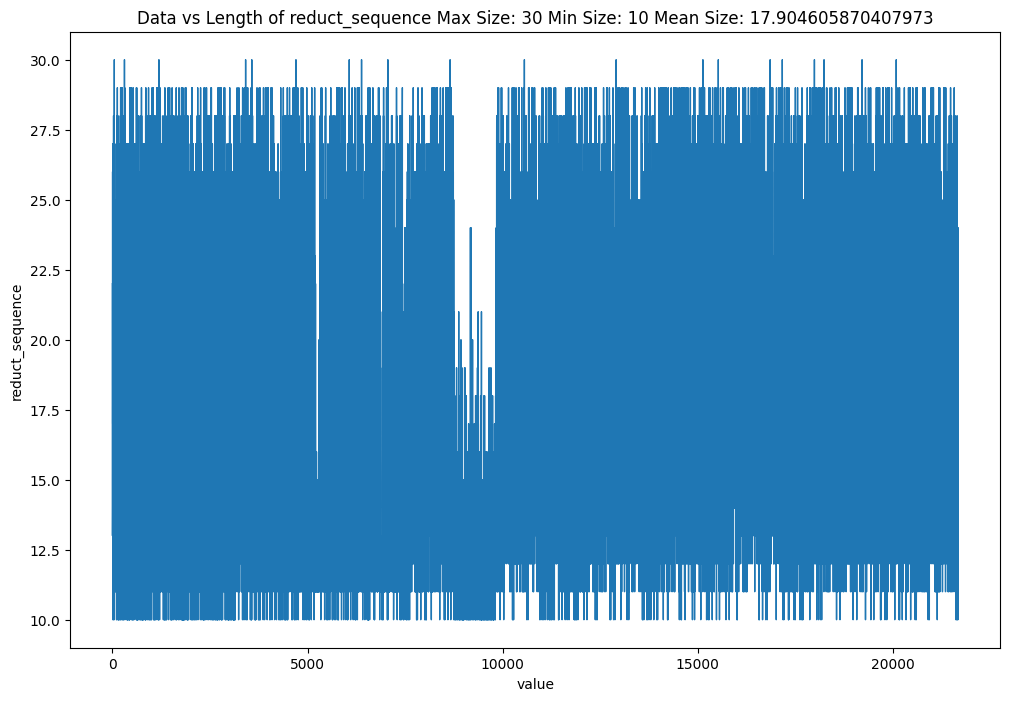

<Figure size 640x480 with 0 Axes>

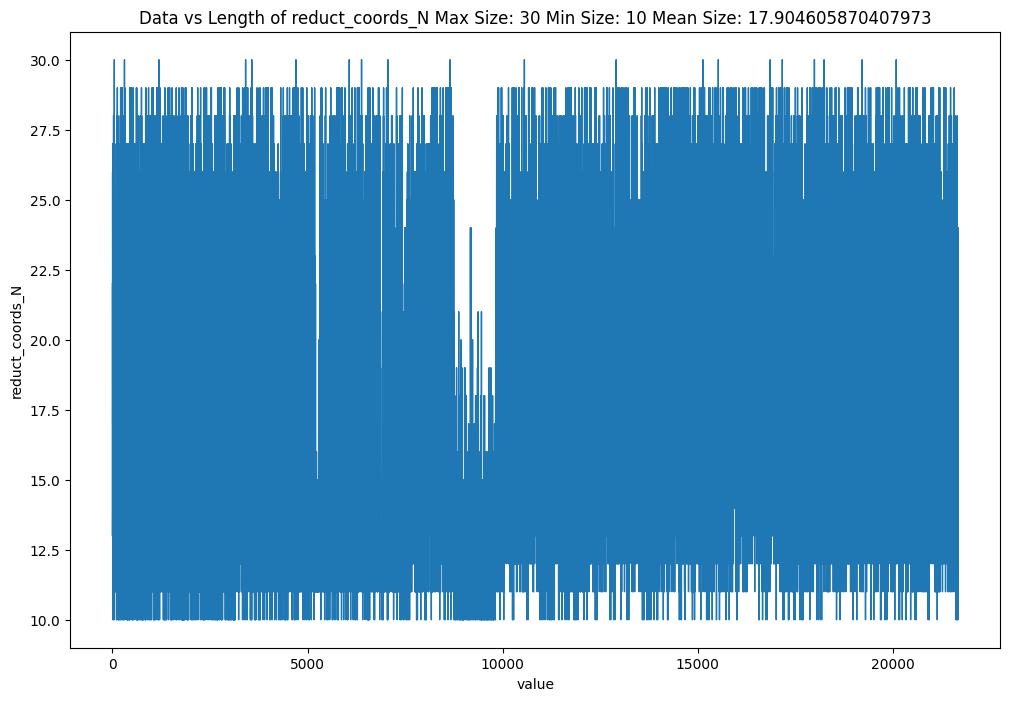

<Figure size 640x480 with 0 Axes>

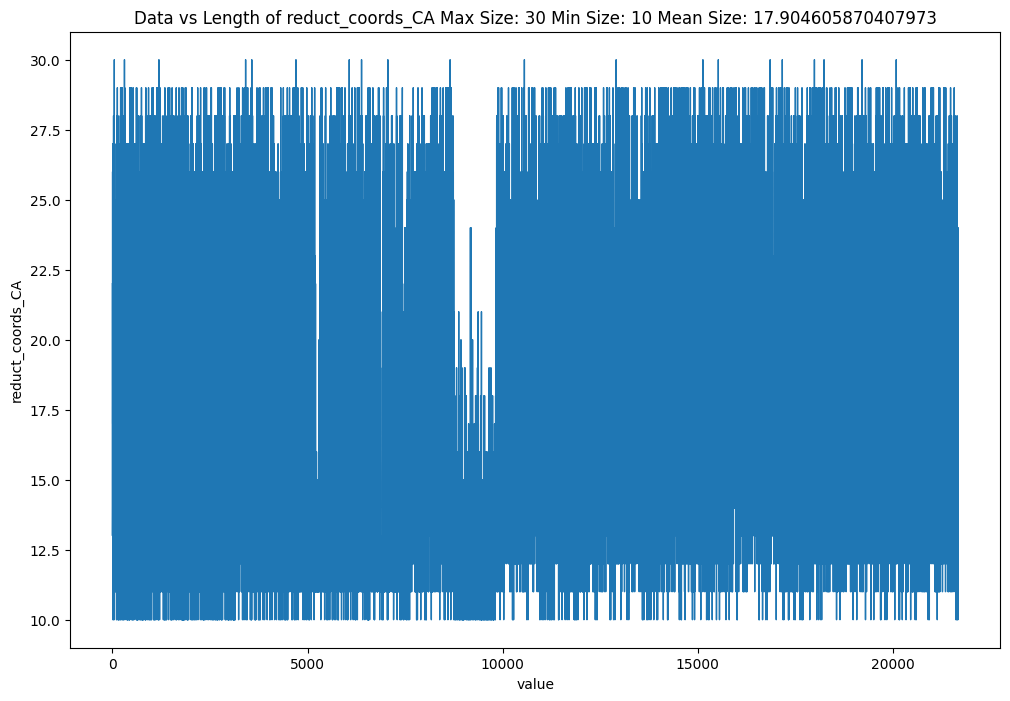

<Figure size 640x480 with 0 Axes>

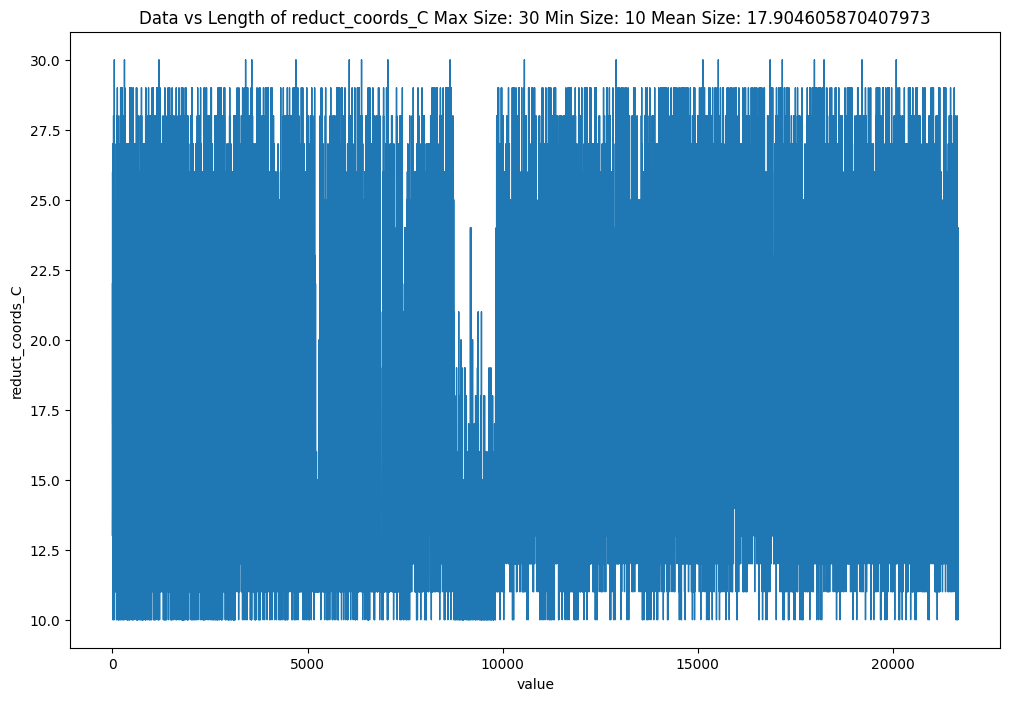

<Figure size 640x480 with 0 Axes>

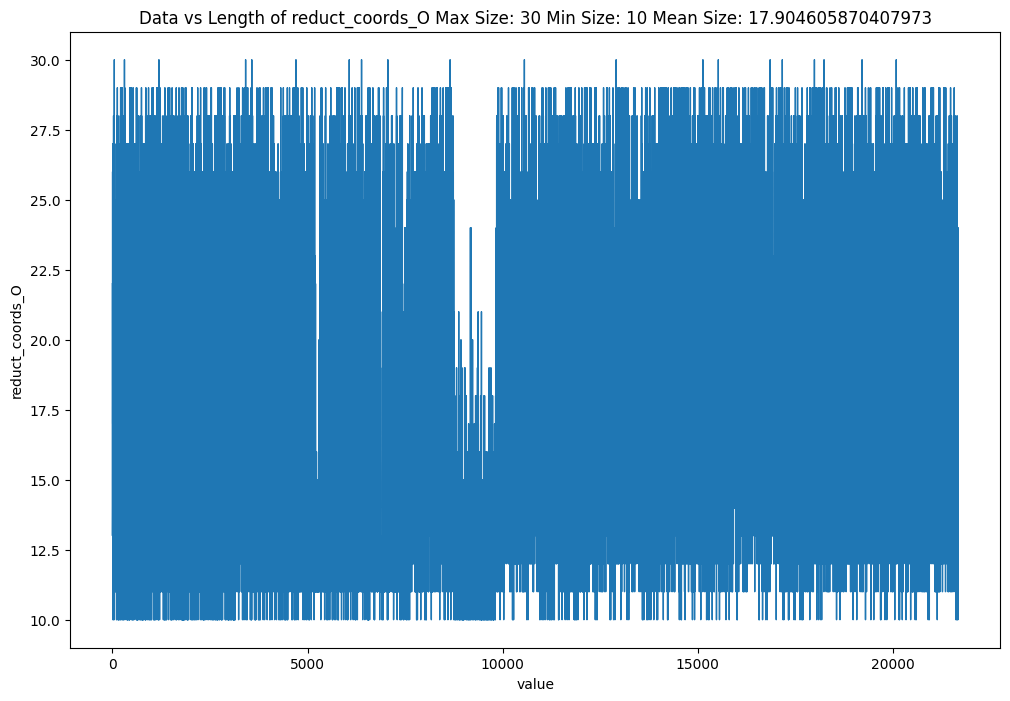

<Figure size 640x480 with 0 Axes>

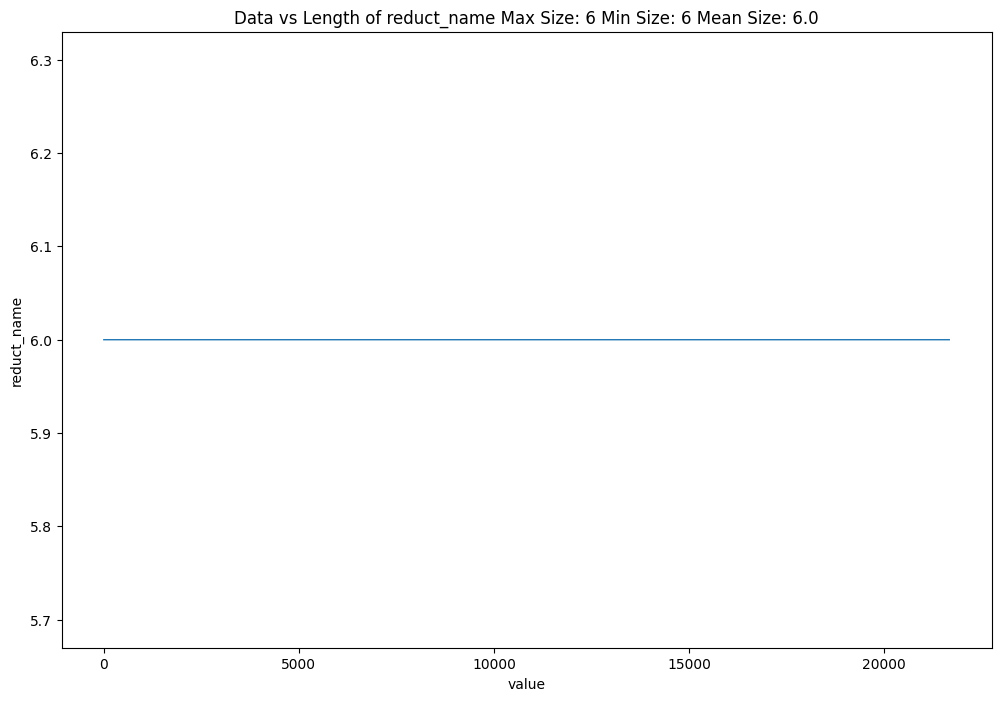

<Figure size 640x480 with 0 Axes>

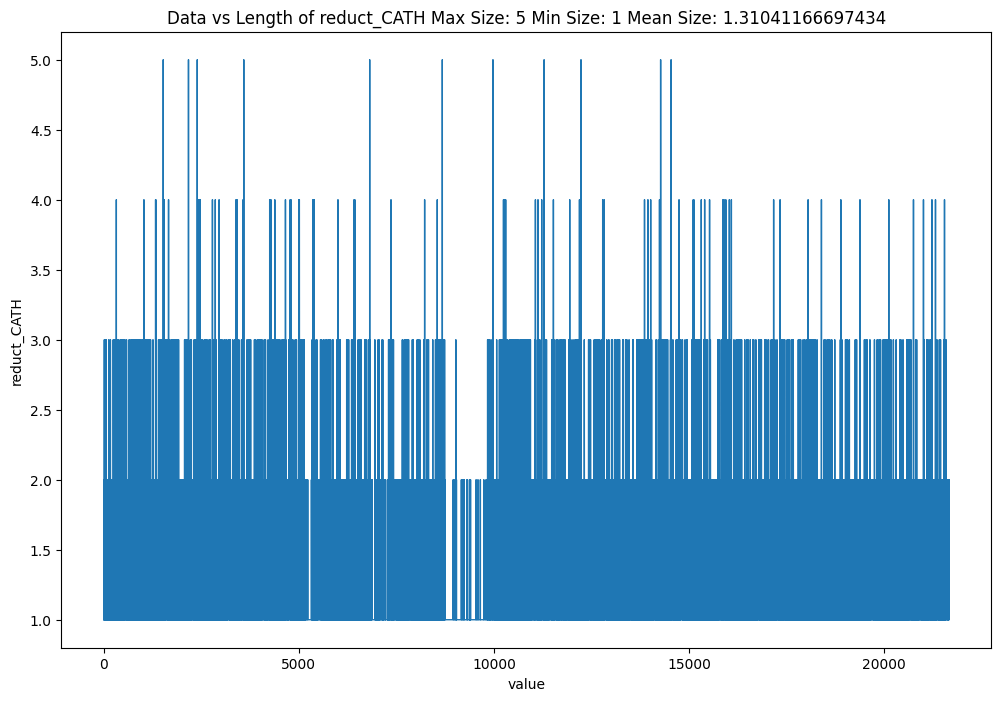

<Figure size 640x480 with 0 Axes>

In [26]:
ik = 0
while ik < len(reduct_array):
  plot_data(len(reduct_array[ik]), reduct_array[ik], analyze_objects[ik])
  ik = ik + 1



In [27]:
new_array = reduct_array[0:5]

# Length of sequence atoms

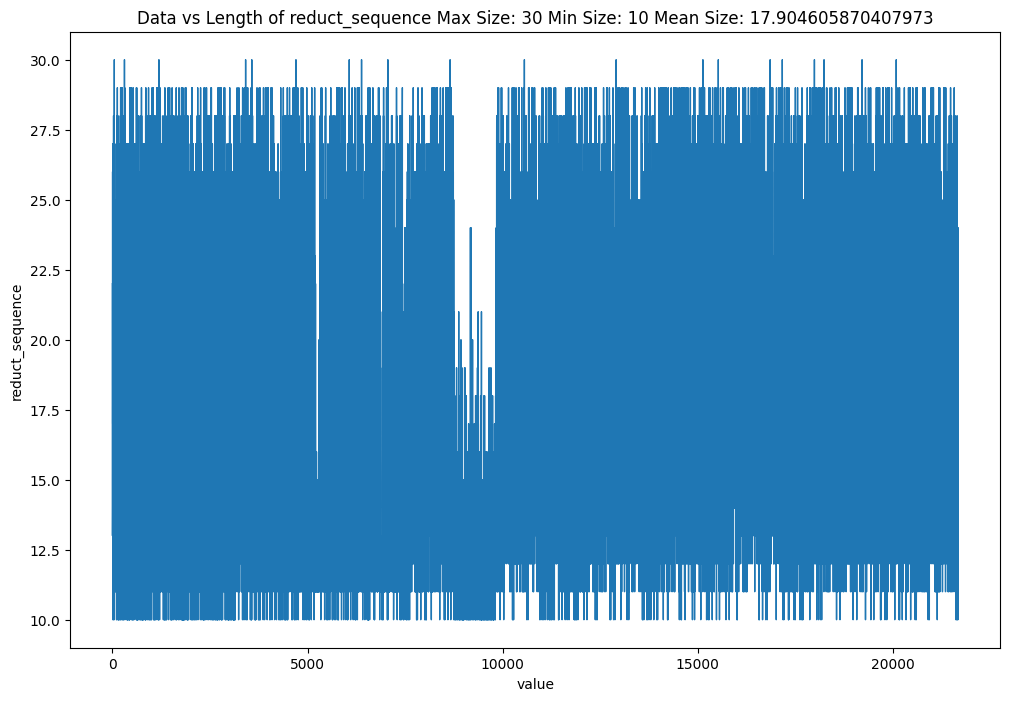

<Figure size 640x480 with 0 Axes>

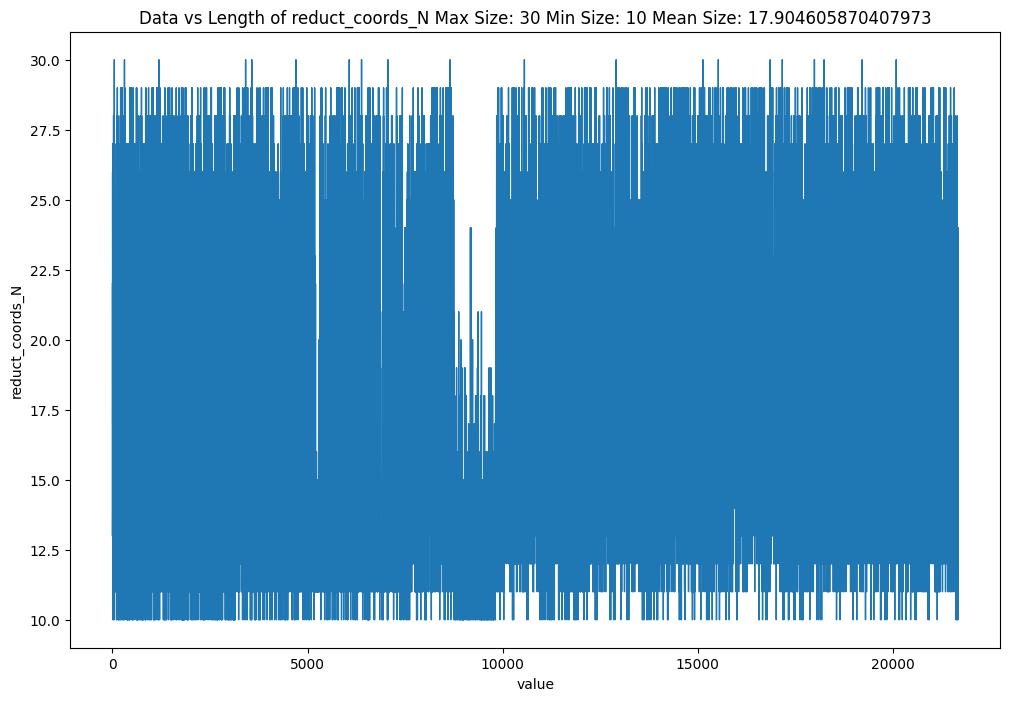

<Figure size 640x480 with 0 Axes>

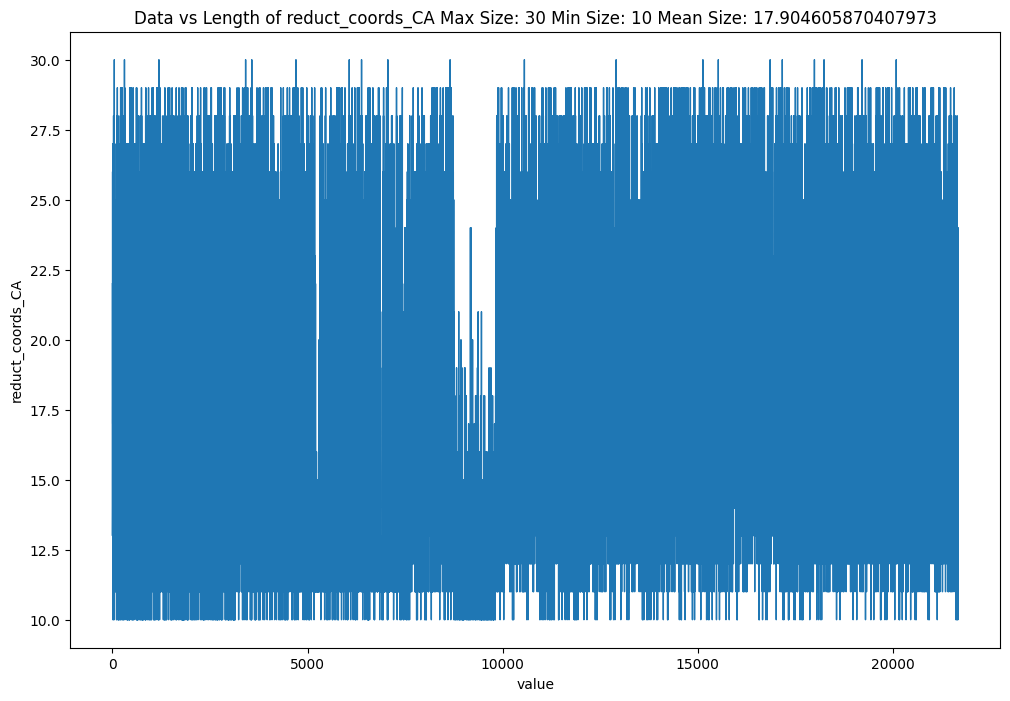

<Figure size 640x480 with 0 Axes>

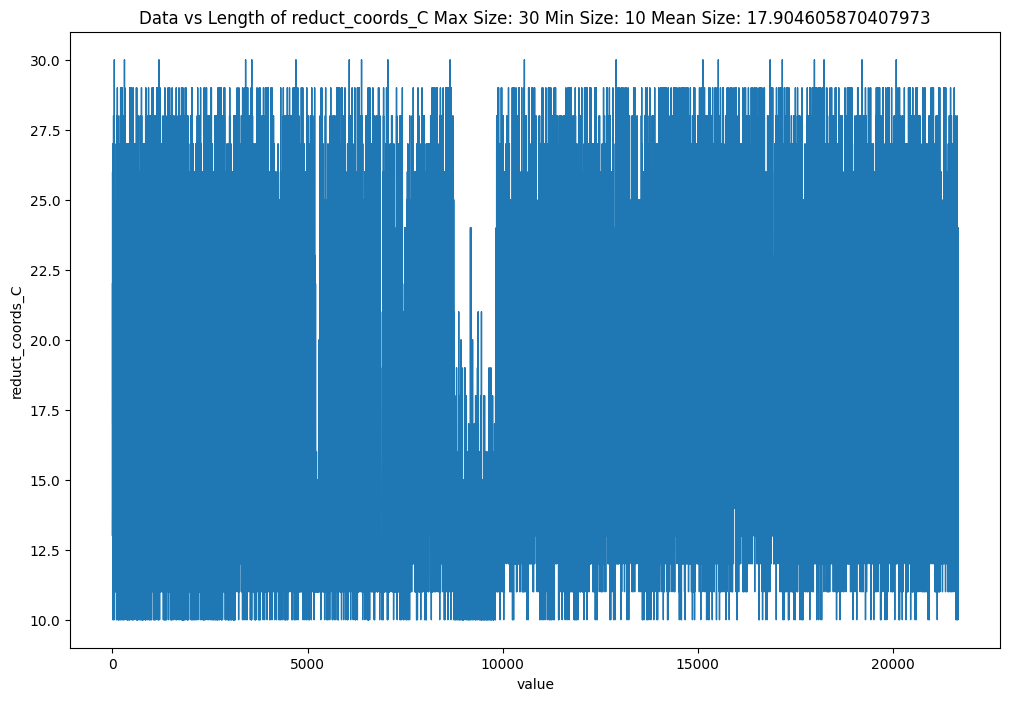

<Figure size 640x480 with 0 Axes>

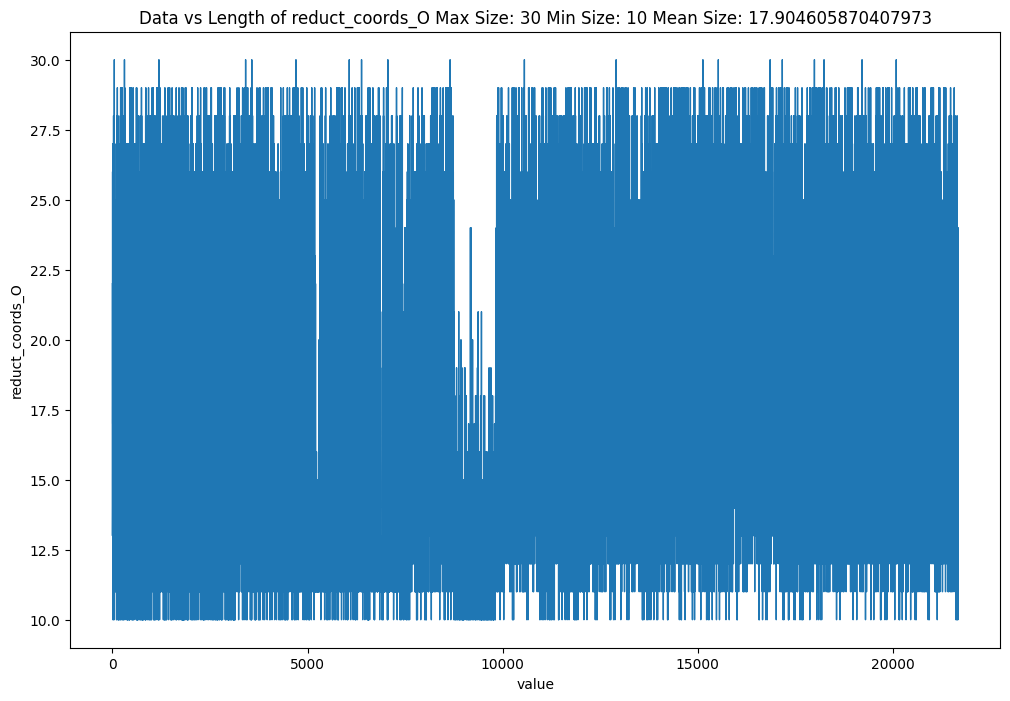

<Figure size 640x480 with 0 Axes>

In [28]:
ik = 0 
while ik < len(new_array):
  plot_data(len(new_array[ik]), new_array[ik], analyze_objects[ik])
  ik = ik + 1

In [29]:
find_index_in_jsonl(json_data[0]["train"][0], jsonl_data)

7866

**Normalize the sequence array**

In [30]:
ij = 0
normalize_sequence = []
while ij < len(reduct_array[0]):
  normalize_sequence.append(normalize_sequence_func(reduct_array[0][ij]))
  ij = ij + 1

In [31]:
len(normalize_sequence)

21668

In [32]:
normalize_sequence_func(reduct_array[0][find_index_in_jsonl(json_data[0]["train"][1], jsonl_data)])

[11, 13, 20, 16, 13, 10, 14, 3, 10, 13, 1, 3, 10, 8, 3, 15]

In [33]:
normalize_array = np.array([normalize_sequence, reduct_coords_N, reduct_coords_CA, reduct_coords_C, reduct_coords_O, reduct_name, reduct_CATH])

<ipython-input-33-814a802cfbb6>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  normalize_array = np.array([normalize_sequence, reduct_coords_N, reduct_coords_CA, reduct_coords_C, reduct_coords_O, reduct_name, reduct_CATH])


It is being considered to assign an array to each of N, CA, C, and O, since they are three-dimensional. They will each have an array in x, y, and z coordinates.

This way, when providing input to VAE and VAE transformer, they will be in the same dimension. Additionally, any nan values will be marked as 0.

In addition, the size of the sequences will be taken as 10 for the initial experiment.

In [34]:
normalize_array[0]


array([list([11, 9, 17, 1, 20, 8, 1, 9, 14, 15, 14, 8, 16, 5, 18, 9, 16, 7, 5, 16, 15, 14]),
       list([9, 18, 5, 6, 15, 2, 4, 10, 1, 1, 1, 11, 9]),
       list([15, 17, 3, 2, 20, 6, 12, 18, 12, 15, 8, 3, 17, 17, 6, 1]),
       ..., list([16, 7, 16, 6, 18, 12, 14, 10, 6, 6, 18, 5, 18, 12]),
       list([21, 11, 14, 9, 20, 18, 2, 12, 18, 2]),
       list([1, 4, 1, 13, 1, 17, 15, 9, 3, 2, 5, 6, 18, 5, 2, 17, 17, 20, 3, 10, 9, 1, 4, 3])],
      dtype=object)

In [35]:
reduct_coords_N_x = []
reduct_coords_N_y = []
reduct_coords_N_z = []
reduct_coords_CA_x = []
reduct_coords_CA_y = []
reduct_coords_CA_z = []
reduct_coords_C_x = [] 
reduct_coords_C_y = []
reduct_coords_C_z = []
reduct_coords_O_x = []
reduct_coords_O_y = []
reduct_coords_O_z = []
ij = 0
while ij < len(reduct_coords_N):
  ik = 0
  while ik < 10:
    reduct_coords_N_x.append(three_d_array_control(reduct_coords_N[ij][ik][0]))
    reduct_coords_N_y.append(three_d_array_control(reduct_coords_N[ij][ik][1]))
    reduct_coords_N_z.append(three_d_array_control(reduct_coords_N[ij][ik][2]))
    reduct_coords_CA_x.append(three_d_array_control(reduct_coords_N[ij][ik][0]))
    reduct_coords_CA_y.append(three_d_array_control(reduct_coords_N[ij][ik][1]))
    reduct_coords_CA_z.append(three_d_array_control(reduct_coords_N[ij][ik][2]))
    reduct_coords_C_x.append(three_d_array_control(reduct_coords_N[ij][ik][0]))
    reduct_coords_C_y.append(three_d_array_control(reduct_coords_N[ij][ik][1]))
    reduct_coords_C_z.append(three_d_array_control(reduct_coords_N[ij][ik][2]))
    reduct_coords_O_x.append(three_d_array_control(reduct_coords_N[ij][ik][0]))
    reduct_coords_O_y.append(three_d_array_control(reduct_coords_N[ij][ik][1]))
    reduct_coords_O_z.append(three_d_array_control(reduct_coords_N[ij][ik][2]))
    ik = ik + 1
  ij = ij + 1



In [36]:
len(reduct_coords_N_z)

216680

In [37]:
ij = 0
sequence_input = []
while ij < len(normalize_sequence):
  ik = 0
  while ik < 10:
    sequence_input.append(normalize_sequence[ij][ik])
    ik = ik + 1
  ij = ij + 1

In [38]:
desired_length = 1000

In [39]:
array_1 = []
array_2 = []
array_3 = []
array_4 = []
array_5 = []
array_6 = []
array_7 = []
array_8 = []
array_9 = []
array_10 = []
array_11 = []
array_12 = []
input_vae = []
input_tensor = []
array_1 = np.array(sequence_input[0:desired_length])
array_2 = np.array(reduct_coords_N_y[0:desired_length])
array_3 = np.array(reduct_coords_N_z[0:desired_length])
array_4 = np.array(reduct_coords_CA_x[0:desired_length])
array_5 = np.array(reduct_coords_CA_y[0:desired_length])
array_6 = np.array(reduct_coords_CA_z[0:desired_length])
array_7 = np.array(reduct_coords_C_x[0:desired_length])
array_8 = np.array(reduct_coords_C_y[0:desired_length])
array_9 = np.array(reduct_coords_C_z[0:desired_length])
array_10 = np.array(reduct_coords_O_x[0:desired_length])
array_11 = np.array(reduct_coords_O_y[0:desired_length])
array_12 = np.array(reduct_coords_O_z[0:desired_length])
input_vae = np.stack((array_1, array_2, array_3, array_4, array_5, array_6, array_7, array_8, array_9, array_10, array_11, array_12), axis = 1)

input_tensor = torch.from_numpy(input_vae).float()

In [40]:
from functions_of_projects import *
train_tensor = []
test_tensor = []
valid_tensor = []
train_tensor = return_tensor(0,1000, sequence_input, reduct_coords_N_y,reduct_coords_N_z,reduct_coords_CA_x,reduct_coords_CA_y,reduct_coords_CA_z,reduct_coords_C_x,reduct_coords_C_y,reduct_coords_C_z,reduct_coords_O_x,reduct_coords_O_y,reduct_coords_O_z)
test_tensor = return_tensor(1000,1033, sequence_input, reduct_coords_N_y,reduct_coords_N_z,reduct_coords_CA_x,reduct_coords_CA_y,reduct_coords_CA_z,reduct_coords_C_x,reduct_coords_C_y,reduct_coords_C_z,reduct_coords_O_x,reduct_coords_O_y,reduct_coords_O_z)
valid_tensor = return_tensor(1033,1095, sequence_input, reduct_coords_N_y,reduct_coords_N_z,reduct_coords_CA_x,reduct_coords_CA_y,reduct_coords_CA_z,reduct_coords_C_x,reduct_coords_C_y,reduct_coords_C_z,reduct_coords_O_x,reduct_coords_O_y,reduct_coords_O_z)

In [41]:
# Hyperparameters
input_size = input_tensor.size(-1) # Giriş boyutu
latent_size = 16
num_heads = 4
num_layers = 2
learning_rate = 0.001
batch_size = 4



**Create model**

In [42]:
input_dim = 12
hidden_dim = 4
kernel_size = 1
dilation_rate = 3 

In [43]:
print(input_tensor.size(-1))

12


In [44]:
num_epochs = 20
batch_size_auto = 12

Epoch 1/20
Training loss_auto: 871.3473510742188
Validation loss_auto: 128.7620849609375
Test loss_auto: 2396.713623046875

Epoch 2/20
Training loss_auto: 738.9240112304688
Validation loss_auto: 111.02799224853516
Test loss_auto: 2144.306884765625

Epoch 3/20
Training loss_auto: 623.3663330078125
Validation loss_auto: 96.57209014892578
Test loss_auto: 1961.8359375

Epoch 4/20
Training loss_auto: 546.1259765625
Validation loss_auto: 86.48375701904297
Test loss_auto: 1821.84716796875

Epoch 5/20
Training loss_auto: 497.8011169433594
Validation loss_auto: 78.54944610595703
Test loss_auto: 1697.75634765625

Epoch 6/20
Training loss_auto: 467.91400146484375
Validation loss_auto: 71.2249984741211
Test loss_auto: 1583.17724609375

Epoch 7/20
Training loss_auto: 450.64617919921875
Validation loss_auto: 64.15618896484375
Test loss_auto: 1477.4307861328125

Epoch 8/20
Training loss_auto: 441.16650390625
Validation loss_auto: 57.46397399902344
Test loss_auto: 1388.1383056640625

Epoch 9/20
Traini

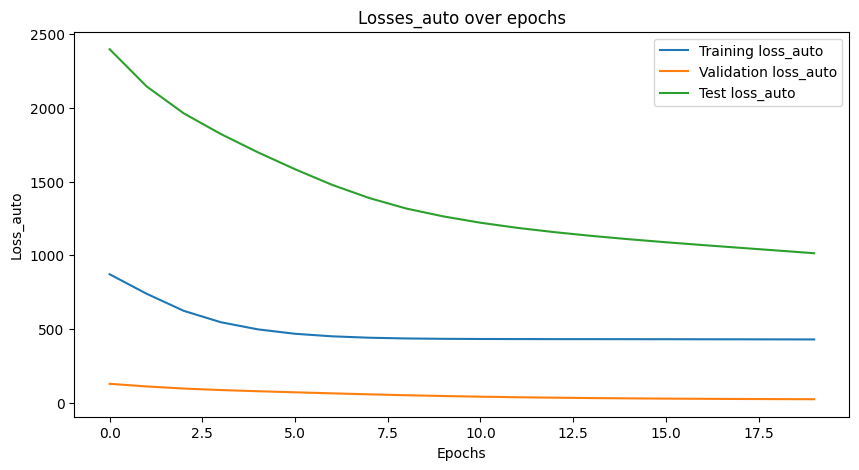

<Figure size 640x480 with 0 Axes>

In [45]:

# Create our model
auto_model = AutoregressiveModel(input_dim, hidden_dim, kernel_size, dilation_rate)
optimizer = torch.optim.Adam(auto_model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

# Metric lists
train_losses_auto = []
valid_losses_auto = []
test_losses_auto = []

best_loss_auto = float("inf")
# Process the data in batches
for epoch in range(num_epochs):
    auto_model.train()

    for i in range(0, len(train_tensor), batch_size_auto):
        batch = train_tensor[i:i+12]

        optimizer.zero_grad()
        # Forward and backward propagation
        if len(batch) == batch_size_auto:
            predicted = auto_model(batch)
            loss = loss_function(predicted, batch)
            loss.backward()
            optimizer.step()

    # Evaluate the model and calculate losses at the end of each epoch
    auto_model.eval()

    with torch.no_grad():
        predicted_train = auto_model(torch.transpose(train_tensor, 0, 1))
        predicted_train = torch.transpose(predicted_train, 0, 1)
        train_loss_auto = loss_function(predicted_train, train_tensor).item()

        predicted_valid = auto_model(valid_tensor[0:batch_size_auto])
        valid_loss_auto = loss_function(predicted_valid[0:batch_size_auto], valid_tensor[0:batch_size_auto]).item()

        predicted_test = auto_model(test_tensor[0:batch_size_auto])
        test_loss_auto = loss_function(predicted_test, test_tensor[0:batch_size_auto]).item()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training loss_auto: {train_loss_auto}")
    print(f"Validation loss_auto: {valid_loss_auto}")
    print(f"Test loss_auto: {test_loss_auto}\n")
    # Save the model if the validation loss is the lowest in this epoch
    if valid_loss_auto < best_loss_auto:
        best_loss_auto = valid_loss_auto
        torch.save(auto_model.state_dict(), "/content/drive/MyDrive/CENG796/best_models/best_auto_model_" + str(num_epochs) + ".pth")
    train_losses_auto.append(train_loss_auto)
    valid_losses_auto.append(valid_loss_auto)
    test_losses_auto.append(test_loss_auto)

# Plot the losses after training
plt.figure(figsize=(10, 5))
plt.plot(train_losses_auto, label='Training loss_auto')
plt.plot(valid_losses_auto, label='Validation loss_auto')
plt.plot(test_losses_auto, label='Test loss_auto')
plt.title('Losses_auto over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss_auto')
plt.legend()
plt.show()
plt.savefig("/content/drive/MyDrive/CENG796/figures/auto_epoch" + str(num_epochs) + ".png")


In [46]:
len(predicted_test[0])

12

In [47]:
# Model creation
vae_model = VAE(input_size, latent_size)
vae_transformer_model = VAETransformer(input_size, latent_size, num_heads, num_layers)

# Optimizer
optimizer = optim.Adam(list(vae_model.parameters()) + list(vae_transformer_model.parameters()), lr=learning_rate)

# Loss function
loss_function = nn.MSELoss()

# Training loop
num_epochs = 20



Epoch 1/20
Training Loss (VAE): 126.3554458618164
Training Loss (VAE Transformer): 956.0813598632812
Validation Loss (VAE): 454.7007751464844
Validation Loss (VAE Transformer): 2616.080078125
Test Loss (VAE): 404.6377258300781
Test Loss (VAE Transformer): 4012.451171875

Epoch 2/20
Training Loss (VAE): 13.321617126464844
Training Loss (VAE Transformer): 786.7915649414062
Validation Loss (VAE): 32.550933837890625
Validation Loss (VAE Transformer): 2347.333740234375
Test Loss (VAE): 38.379173278808594
Test Loss (VAE Transformer): 3602.188720703125

Epoch 3/20
Training Loss (VAE): 5.206026554107666
Training Loss (VAE Transformer): 631.5762939453125
Validation Loss (VAE): 4.383635520935059
Validation Loss (VAE Transformer): 2079.2373046875
Test Loss (VAE): 7.582208156585693
Test Loss (VAE Transformer): 3180.921142578125

Epoch 4/20
Training Loss (VAE): 3.661668300628662
Training Loss (VAE Transformer): 517.741455078125
Validation Loss (VAE): 2.6976985931396484
Validation Loss (VAE Transfor

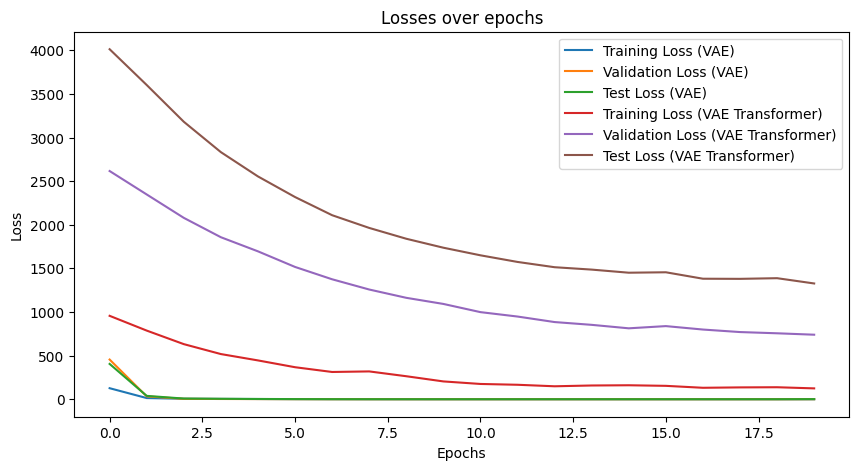

<Figure size 640x480 with 0 Axes>

In [48]:

batch_data = []
scalar_input = []
pairwise_input = []

# Create lists to store metrics
train_losses_vae = []
valid_losses_vae = []
test_losses_vae = []
train_losses_vae_transformer = []
valid_losses_vae_transformer = []
test_losses_vae_transformer = []

best_val_loss = float("inf")  # Initial value to track the best validation loss

for epoch in range(num_epochs):
    vae_model.train()
    vae_transformer_model.train()

    # Process training data in batches
    for i in range(0, len(train_tensor), batch_size):
        batch_data = train_tensor[i:i+batch_size]
        scalar_input = batch_data[:, 0:]
        pairwise_input = batch_data[0:, :]
        
        optimizer.zero_grad()
        
        # Forward and backward propagation for VAE model
        reconstructed_scalar_vae, reconstructed_pairwise_vae, scalar_latent_vae, pairwise_latent_vae = vae_model(scalar_input, pairwise_input)
        vae_loss = loss_function(reconstructed_scalar_vae, scalar_input) + loss_function(reconstructed_pairwise_vae, pairwise_input)
        
        # Forward and backward propagation for VAE Transformer model
        reconstructed_scalar_vae_transformer, reconstructed_pairwise_vae_transformer, scalar_latent_vae_transformer, pairwise_latent_vae_transformer = vae_transformer_model(scalar_input, pairwise_input)
        vae_transformer_loss = loss_function(reconstructed_scalar_vae_transformer, scalar_input) + loss_function(reconstructed_pairwise_vae_transformer, pairwise_input)
        
        total_loss = vae_loss + vae_transformer_loss
        total_loss.backward()
        optimizer.step()


    # Calculate losses and values at the end of each epoch
    vae_model.eval()
    vae_transformer_model.eval()
    
    # Training Loss
    with torch.no_grad():
        scalar_input = train_tensor[:, 0:]
        pairwise_input = train_tensor[0:, :]
        reconstructed_scalar_vae, _, _, _ = vae_model(scalar_input, pairwise_input)
        reconstructed_scalar_vae_transformer, _, _, _ = vae_transformer_model(scalar_input, pairwise_input)
        training_loss_vae = loss_function(reconstructed_scalar_vae, scalar_input).item()
        training_loss_vae_transformer = loss_function(reconstructed_scalar_vae_transformer, scalar_input).item()
    
    # Validation Loss
    with torch.no_grad():
        scalar_input = valid_tensor[:, 0:]
        pairwise_input = valid_tensor[0:, :]
        reconstructed_scalar_vae, _, _, _ = vae_model(scalar_input, pairwise_input)
        reconstructed_scalar_vae_transformer, _, _, _ = vae_transformer_model(scalar_input, pairwise_input)
        validation_loss_vae = loss_function(reconstructed_scalar_vae, scalar_input).item()
        validation_loss_vae_transformer = loss_function(reconstructed_scalar_vae_transformer, scalar_input).item()
    
    # Test Loss
    with torch.no_grad():
        scalar_input = test_tensor[1:, :]
        pairwise_input = test_tensor[:, 0:]
        reconstructed_scalar_vae, _, _, _ = vae_model(scalar_input, pairwise_input)
        reconstructed_scalar_vae_transformer, _, _, _ = vae_transformer_model(scalar_input, pairwise_input)
        test_loss_vae = loss_function(reconstructed_scalar_vae, scalar_input).item()
        test_loss_vae_transformer = loss_function(reconstructed_scalar_vae_transformer, scalar_input).item()

    # Print results at the end of each epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("Training Loss (VAE):", training_loss_vae)
    print("Training Loss (VAE Transformer):", training_loss_vae_transformer)
    print("Validation Loss (VAE):", validation_loss_vae)
    print("Validation Loss (VAE Transformer):", validation_loss_vae_transformer)
    print("Test Loss (VAE):", test_loss_vae)
    print("Test Loss (VAE Transformer):", test_loss_vae_transformer)
    print()

    # Add training, validation, and test losses to the lists
    train_losses_vae.append(training_loss_vae)
    valid_losses_vae.append(validation_loss_vae)
    test_losses_vae.append(test_loss_vae)
    train_losses_vae_transformer.append(training_loss_vae_transformer)
    valid_losses_vae_transformer.append(validation_loss_vae_transformer)
    test_losses_vae_transformer.append(test_loss_vae_transformer)

    # Save the models if the validation loss is the lowest in this epoch
    if validation_loss_vae < best_val_loss:
        best_val_loss = validation_loss_vae
        torch.save(vae_model.state_dict(), "/content/drive/MyDrive/CENG796/best_models/best_vae_model" + str(num_epochs) + ".pth")
        torch.save(vae_transformer_model.state_dict(), "/content/drive/MyDrive/CENG796/best_models/best_vae_transformer_model" + str(num_epochs) + ".pth")

# Plot the losses after training
plt.figure(figsize=(10, 5))
plt.plot(train_losses_vae, label='Training Loss (VAE)')
plt.plot(valid_losses_vae, label='Validation Loss (VAE)')
plt.plot(test_losses_vae, label='Test Loss (VAE)')
plt.plot(train_losses_vae_transformer, label='Training Loss (VAE Transformer)')
plt.plot(valid_losses_vae_transformer, label='Validation Loss (VAE Transformer)')
plt.plot(test_losses_vae_transformer, label='Test Loss (VAE Transformer)')
plt.title('Losses over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig("/content/drive/MyDrive/CENG796/figures/vae_epoch" + str(num_epochs) + ".png")


In [49]:
vae_model_v1 = VAE_v1(input_size, latent_size)
vae_transformer_model_v1 = VAETransformer_v1(input_size, latent_size, num_heads, num_layers)


optimizer_v1 = optim.Adam(list(vae_model_v1.parameters()) + list(vae_transformer_model_v1.parameters()), lr=learning_rate)


loss_function_v1 = nn.MSELoss()

# Eğitim döngüsü
num_epochs = 10


In [50]:
num_epochs = 10

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 12])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12, 999])) that is different to the input size (torch.Size([4, 12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1000, 12])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 

Training Loss (VAE_v1): 1074.4005126953125
Training Loss (VAE Transformer_v1): 1082.4898681640625
Validation Loss (VAE_v1): 3556.348876953125
Validation Loss (VAE Transformer_v1): 2808.547119140625

Training Loss (VAE_v1): 1074.3604736328125
Training Loss (VAE Transformer_v1): 1082.4898681640625
Validation Loss (VAE_v1): 3556.348876953125
Validation Loss (VAE Transformer_v1): 2808.547119140625

Training Loss (VAE_v1): 1074.3236083984375
Training Loss (VAE Transformer_v1): 1082.4898681640625
Validation Loss (VAE_v1): 3556.348876953125
Validation Loss (VAE Transformer_v1): 2808.547119140625

Training Loss (VAE_v1): 1074.2835693359375
Training Loss (VAE Transformer_v1): 1082.4898681640625
Validation Loss (VAE_v1): 3556.348876953125
Validation Loss (VAE Transformer_v1): 2808.547119140625

Training Loss (VAE_v1): 1074.1612548828125
Training Loss (VAE Transformer_v1): 1082.4898681640625
Validation Loss (VAE_v1): 3556.348876953125
Validation Loss (VAE Transformer_v1): 2808.547119140625

Train

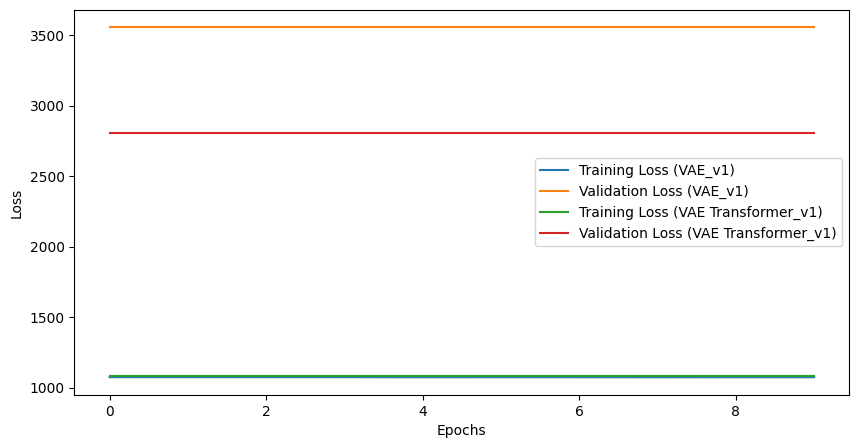

<Figure size 640x480 with 0 Axes>

In [51]:

batch_data = []
batch_data_v1 = []
scalar_input = []
pairwise_input = []
scalar_input_v1 = []
pairwise_input_v1 = []
# Create lists to store metrics
train_losses_vae_v1 = []
valid_losses_vae_v1 = []
test_losses_vae_v1 = []
train_losses_vae_transformer_v1 = []
valid_losses_vae_transformer_v1 = []
test_losses_vae_transformer_v1 = []
reconstructed_pairwise_vae_v1 = []
reconstructed_scalar_vae_transformer_v1 = []
best_val_loss_v1 = float("inf")  # Initial value to track the best validation loss

for epoch in range(num_epochs):
    vae_model_v1.train()
    vae_transformer_model_v1.train()

    # Process training data in batches
    for i in range(0, len(train_tensor), batch_size):
        batch_data = train_tensor[i:i+batch_size]
        batch_data_v1 = train_tensor[i:i+4]
        scalar_input = batch_data[:, 0:]
        pairwise_input = batch_data[0:, :]
        scalar_input_v1 = batch_data_v1[:, 0:]
        pairwise_input_v1 = batch_data_v1[:, :]
        scalar_input_v1 = scalar_input_v1.unsqueeze(2)
        pairwise_input_v1 = pairwise_input_v1.unsqueeze(2)
        optimizer.zero_grad()

        # Forward and backward propagation for VAE_v1 model
        reconstructed_scalar_vae_v1, reconstructed_pairwise_vae_v1, scalar_latent_vae_v1, pairwise_latent_vae_v1 = vae_model_v1(scalar_input_v1, pairwise_input_v1)
        vae_loss_v1 = loss_function_v1(reconstructed_scalar_vae_v1, scalar_input_v1) + loss_function(reconstructed_pairwise_vae_v1, pairwise_input_v1)

        # Forward and backward propagation for VAE Transformer_v1 model
        reconstructed_scalar_vae_transformer_v1, reconstructed_pairwise_vae_transformer_v1, scalar_latent_vae_transformer_v1, pairwise_latent_vae_transformer_v1 = vae_transformer_model_v1(scalar_input, pairwise_input)
        vae_transformer_loss_v1 = loss_function(reconstructed_scalar_vae_transformer_v1, scalar_input) + loss_function(reconstructed_pairwise_vae_transformer_v1, pairwise_input)
                
        total_loss = vae_loss_v1 + vae_transformer_loss_v1
        total_loss.backward()
        optimizer.step()


    # Calculate losses and values at the end of each epoch
    vae_model_v1.eval()
    vae_transformer_model_v1.eval()    
    # Training Loss
    with torch.no_grad():
        scalar_input = train_tensor[:, 0:]
        pairwise_input = train_tensor[0:, :]
        scalar_input_v1 = train_tensor[1:, :]
        pairwise_input_v1 = train_tensor[0:, :]
        scalar_input_v1 = torch.transpose(scalar_input_v1, 0, 1)
        reconstructed_scalar_vae_transformer_v1, _, _, _ = vae_transformer_model_v1(scalar_input, pairwise_input)
        training_loss_vae_v1 = loss_function(reconstructed_scalar_vae_v1, scalar_input_v1).item()
        training_loss_vae_transformer_v1 = loss_function(reconstructed_scalar_vae_transformer_v1, scalar_input).item()    
    # Validation Loss
    with torch.no_grad():
        scalar_input = valid_tensor[:, 0:]
        pairwise_input = valid_tensor[0:, :]
        scalar_input_v1 = valid_tensor[46:, 0:]
        pairwise_input_v1 = valid_tensor[46:, :]
        scalar_input_v1 = torch.transpose(scalar_input_v1, 0, 1)
        pairwise_input_v1 = torch.transpose(pairwise_input_v1, 0, 1)
        reconstructed_scalar_vae_v1, _, _, _ = vae_model_v1(scalar_input_v1, pairwise_input_v1)
        reconstructed_scalar_vae_transformer_v1, _, _, _ = vae_transformer_model_v1(scalar_input, pairwise_input)
        validation_loss_vae_v1 = loss_function(reconstructed_scalar_vae, scalar_input[0:32]).item()
        validation_loss_vae_transformer_v1 = loss_function(reconstructed_scalar_vae_transformer_v1, scalar_input).item()
    
    # Print results at the end of each epoch
    print("Training Loss (VAE_v1):", training_loss_vae_v1)
    print("Training Loss (VAE Transformer_v1):", training_loss_vae_transformer_v1)
    print("Validation Loss (VAE_v1):", validation_loss_vae_v1)
    print("Validation Loss (VAE Transformer_v1):", validation_loss_vae_transformer_v1)
    print()

    # Add training, validation, and test losses to the lists
    train_losses_vae_v1.append(training_loss_vae_v1)
    valid_losses_vae_v1.append(validation_loss_vae_v1)
    train_losses_vae_transformer_v1.append(training_loss_vae_transformer_v1)
    valid_losses_vae_transformer_v1.append(validation_loss_vae_transformer_v1)

    # Save the models if the validation loss is the lowest in this epoch
    if validation_loss_vae_v1 < best_val_loss_v1:
        best_val_loss_v1 = validation_loss_vae_v1
        torch.save(vae_model_v1.state_dict(), "/content/drive/MyDrive/CENG796/best_vae_model_v1.pth")
        torch.save(vae_transformer_model_v1.state_dict(), "/content/drive/MyDrive/CENG796/best_vae_transformer_model_v1.pth")

# Plot the losses after training
plt.figure(figsize=(10, 5))
plt.plot(train_losses_vae_v1, label='Training Loss (VAE_v1)')
plt.plot(valid_losses_vae_v1, label='Validation Loss (VAE_v1)')
plt.plot(train_losses_vae_transformer_v1, label='Training Loss (VAE Transformer_v1)')
plt.plot(valid_losses_vae_transformer_v1, label='Validation Loss (VAE Transformer_v1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig("/content/drive/MyDrive/CENG796/figures/vae_v1_epoch" + str(num_epochs) + ".png")


In [52]:
n_array = np.zeros((3, 32), dtype=float)
ca_array = np.zeros((3, 32), dtype=float)
c_array = np.zeros((3, 32), dtype=float)
o_array = np.zeros((3, 32), dtype=float)

In [53]:

ij = 0
de_norm_sequence = []
n_array = np.zeros((3, 32), dtype=float)
ca_array = np.zeros((3, 32), dtype=float)
c_array = np.zeros((3, 32), dtype=float)
o_array = np.zeros((3, 32), dtype=float)
error = 0
while ij < len(reconstructed_scalar_vae):
  val = int(reconstructed_scalar_vae[ij][0])
  if (val > 26):
    val = random_number = random.randint(0, 26)
    error = error + 1
  elif(val == 0):
    val = 1
  n_array[0][ij] = reconstructed_scalar_vae[ij][1]
  n_array[1][ij] = reconstructed_scalar_vae[ij][1]
  n_array[2][ij] = reconstructed_scalar_vae[ij][2]

  ca_array[0][ij] = reconstructed_scalar_vae[ij][3]
  ca_array[1][ij] = reconstructed_scalar_vae[ij][4]
  ca_array[2][ij] = reconstructed_scalar_vae[ij][5]

  c_array[0][ij] = reconstructed_scalar_vae[ij][6]
  c_array[1][ij] = reconstructed_scalar_vae[ij][7]
  c_array[2][ij] = reconstructed_scalar_vae[ij][8]

  o_array[0][ij] = reconstructed_scalar_vae[ij][9]
  o_array[1][ij] = reconstructed_scalar_vae[ij][10]
  o_array[2][ij] = reconstructed_scalar_vae[ij][11]

  de_norm_sequence.append(val)
  ij = ij + 1
error_rate = error/len(de_norm_sequence)


In [54]:
de_norm_sequence_final = denormalize_sequence_func(de_norm_sequence)

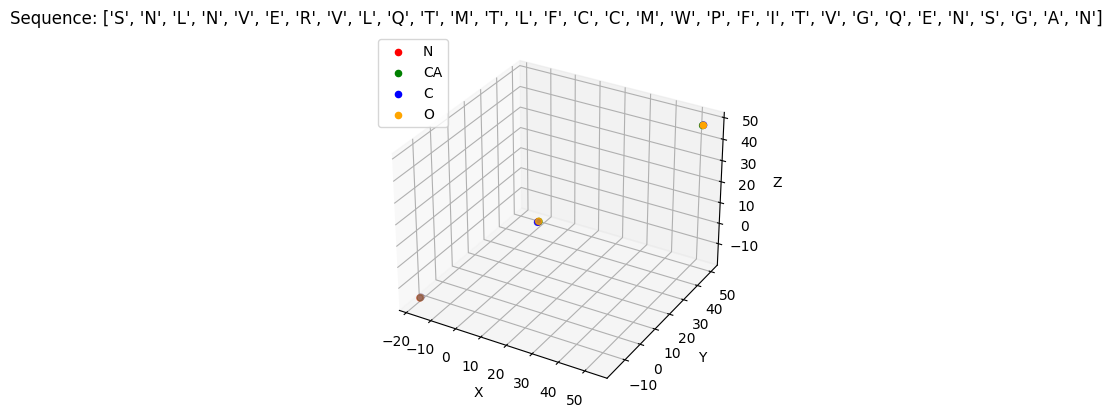

<Figure size 640x480 with 0 Axes>

In [55]:
sequence = str(de_norm_sequence_final) # Başlık metni

plot_atoms(n_array, ca_array, c_array, o_array, sequence, num_epochs)


In [56]:


# Load PDB file as text
with open("/content/drive/MyDrive/CENG796/1wte.pdb", 'r') as f:
    pdb_data = f.read()

# Create a new viewer and add the model
viewer = py3Dmol.view()
viewer.addModel(pdb_data, 'pdb')

# Set style and zoom
viewer.setStyle({'cartoon': {'color':'spectrum'}})
viewer.zoomTo()

# Show the viewer
viewer.show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#**Difficulties**

**General Difficulties**

Due to the large size of the CATH4.2 dataset used for protein design, several issues have emerged in the dataset arrangement. Additionally, 3D protein design presents challenges in terms of GPU and RAM usage. The complexity of the methods used in the study and the absence of a code repository also make it difficult to reproduce the model.

Furthermore, the code considered the entire dimension of the coordinates, which turned out to be 15,134,349 in length. As a result, some simplifications and data cleaning operations need to be performed first. However, great care must be taken when processing the data to ensure accurate 3D protein prediction.

**Dataset**

A significant number of attempts were made to rearrange the dataset and run the model, and the necessary adjustments were made accordingly. Evaluating the dataset was crucial to determine whether the desired values could be generated due to the size and complex 3D structure of the protein sequences. Each step was carefully checked and validated.

**Model**

Various models were tried for the VAE, but the model was incorporated into the system in the most suitable way considering the environment and integration with the dataset. Eventually, a model was used without encountering errors.

**Results**

Since the expected results were for 3D protein design, which is not entirely feasible in this environment, the desired results could not be precisely generated. However, the 3D rendering of the protein that can be predicted was performed, and it is indicated in main.ipynb. Additionally, efforts were made to save versions as errors were encountered and resolved, aiming to minimize any loss. As a result, 3D protein design predictions were made, and the results were plotted to obtain the final outcomes. 

As a result, trials were carried out in different epochs and 5 different models. While we can say that the results of 3 models are successful, we can say that 2 results are unsuccessful. In addition, unlike articles and literature reviews, the data set was studied to the finest detail. Although the result was not as desired, a study that can be developed in the future has thus been put forward.
